## CS 4740 (+crosslists) Sp'25 HW2: Named-entity recognition using FFNNs and RNNs


In this assignment, you will train neural networks, specifically feedforward neural networks (FFNN) and recurrent neural networks (RNN) for the same named entity recognition task as HW1.

__Deadlines__: This assignment has 2 deadlines -  a __milestone submission__ <font color="red">(due March 12, 11.59 p.m)</font> <a name="footnote2"></a><sup>[1]</sup>, and a __final submission__ <font color="red">(due March 21, 11.59 p.m.)</font>. This notebook will walk you through the assignment step-by-step, including how to make the milestone and final submissions.

<a name="optional"></a><sup>[1] </sup> Note that passing the milestone doesn't guarantee full correctness of the tested components (you should be writing your own test cases to assure that!). Upon final submission, your code will be tested on several additional test cases.

<br>

__Tl;dr of structure of the assignment__: In Section 1 and Section 2, you will learn to manipulate the input data (provided in the same format as HW1) into structures that can be ingested by neural networks. In Section 3, you will implement the functionality to train and evaluate any neural network. In Section 4, you will implement your FFNNs. In Section 5, you will implement RNNs.


<br>


__Policies.__ All the policies described on the course website are applicable as is (including the policy on academic integrity and the use of generative AI tools), for more information, see: https://www.cs.cornell.edu/courses/cs4740/2025sp/#17723d1a-3753-80ec-9b99-d86194c0dbd2.



---

<a name="outline"></a>__Assignment outline__

* [[$\ast$] Attributions](#attr)
* [[0] Imports and installs!](#sec0)
* [[1] Data processing](#sec1)
  * [[1.1] Tokenization](#sec11)
  * [[1.2] Data collation](#sec12)
* [[2] Embeddings](#sec2)
* [[3] The training, evaluation loop](#sec3)
* [[$\ast$] Milestone submission](#milestone)
* [[4] FFNNs](#sec4)
  * [[4.1] Single-layer FFNN](#sec41)
  * [[4.2] Multi-layered FFNN](#sec42)
  * [[$\ast$] Leaderboard submission](#leaderboard_ffnn) ← optional!<a name="footnote2"></a>[<sup>[2]</sup>](#optional)
  * [[4.3] Analyzing FFNN](#sec43)
* [[5] RNNs, or "multilayer machines with loops!"](#sec5)
  * [[5.1] Single-layer vanilla RNN](#sec51)
  * [[5.2] Multi-layered RNN](#sec52)
  * [[$\ast$] Leaderboard submission](#leaderboard_rnn) ← optional!<a name="footnote2"></a>[<sup>[2]</sup>](#optional)
  * [[5.3] Analyzing RNN](#sec53)
* [[$\ast$] Final submission](#final)

> <a name="optional"></a><sup>[2] </sup>The leaderboard submission is private (your scores are not visible to other students) and using the leaderboard is optional. This is just for you to test your models' performance on the test sets. You are __limited to 5 submissions per day__ for the leaderboard submission.
>
> That said, we _will_ run your models, both FFNN and RNN ([from your final submission](#final)), and you will be graded on the submitted models' test performance, measured as weighted-average entity-level F1. <font color="red">To receive full credit, your FFNN must beat the baseline of 0.40 and RNN must beat the baseline of 0.65.</font> If the model scores below the set baseline, the associated performance points will be a linear function of the score [= being close to the baseline guarantees majority of the credit]. [↩︎](#footnote2)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

<a name="attr"></a>

### [$\ast$] Attributions <small>[↩︎](#outline)</small>

Please use the space provided below to acknowledge (by name/source) all help you received (this includes generative AI tools). You're welcome to cite references in line when answering the "written" questions.

_Attributions (if any) go here._

---

<a name="sec0"></a>
### [0] Imports and installs! <small>[↩︎](#outline)</small>

Run the following code to install any external libraries and needed packages to run HW2 assignment. Before proceeding, be sure to run the second code cell to ensure that the installation is successful.

> __Tip.__ Google Colab also allows you to connect one GPU for free. You can add this to your runtime by going to “Runtime → Change runtime type → T4 GPU"

> __Tip.__ It is possible to run out of GPU cycles on Colab, even if the GPU is sitting idle (but connected); we strongly recommend that you use CPU while you experiment, develop your code, then transition to using a GPU to run the final experiments.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

# set to location where you uploaded directory
%cd "/content/drive/MyDrive/cs4740_hw2/hw2-release"
%pip install -r requirements.txt

import IPython

ipython = IPython.get_ipython()
ipython.run_line_magic("sx", f"chmod +x scripts/*.py")

ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs4740_hw2/hw2-release


In [3]:
from IPython.display import display

try:
    from ner.utils.utils import success, colored
    print(colored("Installation successful!\n", "green"))
    display(success())
except ImportError:
    print("\033[31mInstallation failed, please retrace your steps ...")

Installation successful!



A few imports that will be needed throughout this notebook are imported below. Within this notebook, feel free to import and/or install packages (a lot of the packages you may need should already be available) as you see fit; <font color="red">however, you are __not__ allowed to modify the imports in any of the Python source files; further, please do not modify (delete lines, change method signatures, etc.) above or below the `TODO` placeholders within the Python source files.</font>

In [4]:
import os
from collections import Counter
from itertools import chain

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import yaml
from IPython.display import display

from ner.data_processing.constants import NER_ENCODING_MAP
from ner.data_processing.tokenizer import Tokenizer
from ner.models.ner_predictor import NERPredictor
from ner.utils.utils import success, colored
from ner.utils.visualize import inspect_preds, visualize_activations

%matplotlib inline
%config InlineBackend.figure_format="retina"

Let's setup a few paths! For convenience, we will redirect all the output artefacts to the `cs4740-hw2/artefacts` directory—this includes processed dataset, tokenizer files, experimental artefacts (configs, saved checkpoints, trained models, etc.), submission zip files, etc.

In [5]:
BASE_DIR = os.path.abspath(".")
ARTEFACTS_DIR = os.path.join(BASE_DIR, "artefacts")
SCRIPTS_DIR = os.path.join(BASE_DIR, "scripts")
CONFIGS_DIR = os.path.join(BASE_DIR, "scripts/configs")

Finally, set your and your partner's net IDs as a comma-separated string _without_ spaces (e.g., "`<net-id-1>`,`<net-id-2>`"); we'll use the `net_ids` variable to auto-populate any required information while making the submission.

In [6]:
# Add your net IDs as a comma-separated string without spaces (e.g., "<net-id-1>,<net-id-2>").
net_ids = 'aeh245' #e.g. 'tg436'

if net_ids is None:
    raise ValueError("net-IDs not set; set them above")

---

<a name="sec1"></a>
### [1] Data processing <small>[↩︎](#outline)</small>

We will be using a dataset with the same structure as the HW1 dataset .json files are located in the `hw2-sp25/dataset` folder. For convenience, we will be converting these .json files into an [arrow dataset](https://huggingface.co/docs/datasets/about_arrow). For the purposes of this assignment, we'll walk you through data access with an arrow dataset (don't worry, it's as simple as accessing a dictionary!).

Run the cell below to convert the .json data files into an arrow dataset (for those curious about the script, please see the documentation website). The processed dataset will be stored in `cs4740-hw2/artefacts/dataset` folder.

> __Tip.__ For any of the scripts provided, you can run `!<command-name> --help` to see the arguments of the command! <br/>
> (Replace the `<command-name>` accordingly.)

In [7]:
!python -m scripts.create_hf_dataset \
    --basepath-to-dataset-json-files={os.path.join(BASE_DIR, "dataset")} \
    --path-to-store-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")}

Saving the dataset (1/1 shards): 100% 92720/92720 [00:02<00:00, 43331.83 examples/s]
Saving the dataset (1/1 shards): 100% 11590/11590 [00:00<00:00, 19633.38 examples/s]
Saving the dataset (1/1 shards): 100% 11597/11597 [00:00<00:00, 23348.13 examples/s]


> __Tip.__ (This tip applies to all commands that save run artefacts.) The above cell stores the run artefact (here, dataset) and you don't need to rerun the above cell to re-populate the artefact; instead, just load the artefact from the `cs4740-hw2/artefacts` folder) as shown below.

In [8]:
hf_dataset = datasets.load_from_disk(os.path.join(ARTEFACTS_DIR, "dataset"))
print(hf_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'NER', 'index'],
        num_rows: 92720
    })
    val: Dataset({
        features: ['text', 'NER', 'index'],
        num_rows: 11590
    })
    test: Dataset({
        features: ['text', 'index'],
        num_rows: 11597
    })
})


The following cell shows how to access a specific split [= "train", "val", or "test"] of the `hf_dataset`, and a specific sample (accessed by index). You should observe that each sample of train/val splits includes three fields: "text", "index", and "NER", while the test split has two fields: "text" and "index". (This is consistent with what you observed in HW1.)

Go on, try to access the "text" and "NER" fields of the chosen sample; what's the datatype of the "text" field?

In [9]:
split, sample_idx = "train", 5
hf_dataset[split][sample_idx]

# Try to access "text" and "NER" fields of the chosen sample.

{'text': ['Next',
  'is',
  'the',
  'Adolf-Hitler-Platz',
  ',',
  'a',
  'grand',
  'public',
  'square',
  'for',
  'rallies',
  'and',
  'such',
  '.'],
 'NER': ['O',
  'O',
  'O',
  'B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'index': ['119',
  '120',
  '121',
  '122',
  '123',
  '124',
  '125',
  '126',
  '127',
  '128',
  '129',
  '130',
  '131',
  '132']}

<a name="sec11"></a>
#### [1.1] Tokenization <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `ner/data_processing/tokenizer.py`.

From the previous section, you would notice that the "text" field is of type `List`, i.e., the text is already given to you as tokens! But wait, these are strings, and we need numerical data to use neural approaches (why?). Before proceeding, it is worth looking at the class methods (provided to you) in the `Tokenizer` class: you will find the documentation website to be extemely helpful.

You will be completing <font color="orange">`TODO-1.1-1`</font> in the `tokenize()` method; pay attention to the class constructor and class variables. What is expected from `tokenize()`?:
* note from the input type of `input_seq` that it can be a `str` or `List[str]`—to keep consistent, if it's a string, convert it to a list of space-separated strings,
* `self.lowercase` is a class variable that determines tokenizer's case-handling behavior; be sure to handle this while tokenizing, and
* we need to "somehow" represent strings as integers (a.k.a, input IDs); the `Tokenizer` maintains `self.token2id` for this specific purpose; use [`torch.LongTensor`](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Ftensors.html) to convert a list of input IDs into a tensor of _integer_ values.

For now, let's return a dictionary with (string) `"input_ids"` as the key and associated `LongTensor` of input IDs as the value. An example output is as follows:
```
{"input_ids": tensor([2, 3, 4, 1, 0, 0])}
```

Run the cell below to test that everything runs as expected; we strongly recommend that you modify the code in the cell below to add your own tests.

In [10]:
from ner.data_processing.constants import PAD_TOKEN, UNK_TOKEN
from ner.data_processing.tokenizer import Tokenizer

tokenizer = Tokenizer(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN, lowercase=False)
tokenizer.from_dict({PAD_TOKEN: 0, UNK_TOKEN: 1, "I": 2, "am": 3, "Naruto": 4})  # stub the tokenizer
tokenizer.tokenize(input_seq="I am Naruto Uzumaki")

{'input_ids': tensor([2, 3, 4, 1]), 'padding_mask': tensor([0, 0, 0, 0])}

Now that the basic tokenization runs as expected, let's move on to handling the `max_length` constraint. The length of the sequence to be returned must exactly match the provided `max_length`, i.e., if `max_length` is provided, (if needed,) we need to either pad the sequence with `self.pad_token`, or truncate the sequence. Pay special attention to the `padding_side` and `truncation_side` parameters; these indicate which side to pad/truncate from.

To keep track of what is padded and what isn't, we will also return a padding mask of `max_length` which is "$1$" at all indices where the corresponding token is a `self.pad_token` and "$0$" elsewhere. Here's an example to illustrate the same:

> padded tokens: ["I", "am", "Naruto", "Uzumaki", `PAD_TOKEN`, `PAD_TOKEN`] <br/>
> input IDs: [2, 3, 4, 1, 0, 0] <br/>
> padding mask: [0, 0, 0, 0, 1, 1]

You might find [`torch.where`](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Fgenerated%2Ftorch.where.html) to be helpful here. Upon completion, return a dictionary with (strings) `"input_ids"` and `"padding_mask"` as keys and associated tensors as values. An example output is as follows:

```
{
    "input_ids": tensor([2, 3, 4, 1, 0, 0]),
    "padding_mask": tensor([0, 0, 0, 0, 1, 1]),
}
```

Let's re-use our example from before and see if everything runs as expected.

In [11]:
tokenizer = Tokenizer(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN, lowercase=False)
tokenizer.from_dict({PAD_TOKEN: 0, UNK_TOKEN: 1, "I": 2, "am": 3, "Naruto": 4})  # stub the tokenizer
tokenizer.tokenize(input_seq="I am Naruto Uzumaki")

{'input_ids': tensor([2, 3, 4, 1]), 'padding_mask': tensor([0, 0, 0, 0])}

Yay! Now that we've completed the tokenization part, we can finally train our own tokenizer using the training data. To train the tokenizer, we will be using the `Tokenizer.train()` class method—observe that this method uses `min_freq` and `remove_frac` to manage the vocabulary size. (We redirect you to the documentation website for more specifics.)

The following code cell shows you the effect of `min_freq` and `remove_frac` parameters on the vocabulary size.

> __Note.__ Our `Tokenizer.train()` applies `remove_frac` filtering on `min_freq`-filtered output (not the other way around). To simulate this behavior, we use the `min_freq_for_remove_frac` variable below; change this accordingly to see the aggregated effect of applying `remove_frac` over `min_freq` (with `min_freq_for_remove_frac`) filtering.

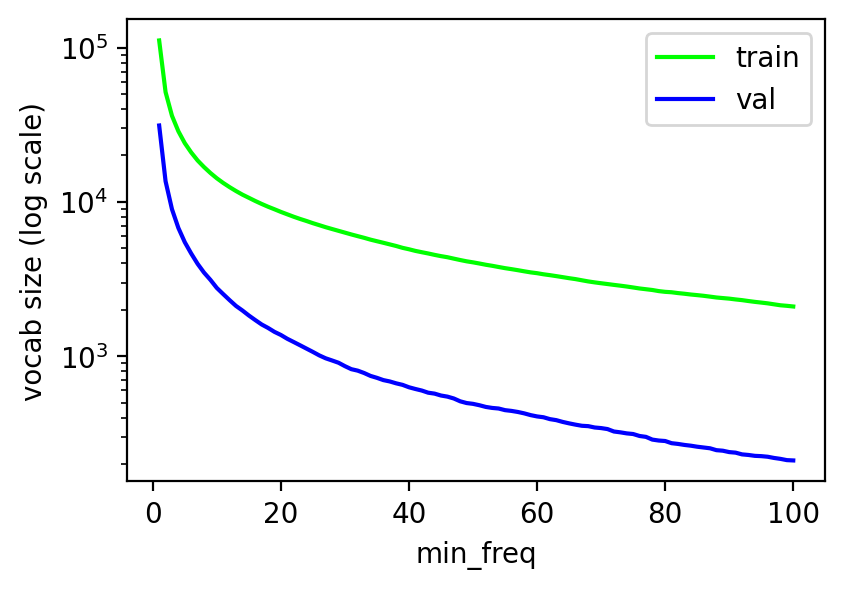

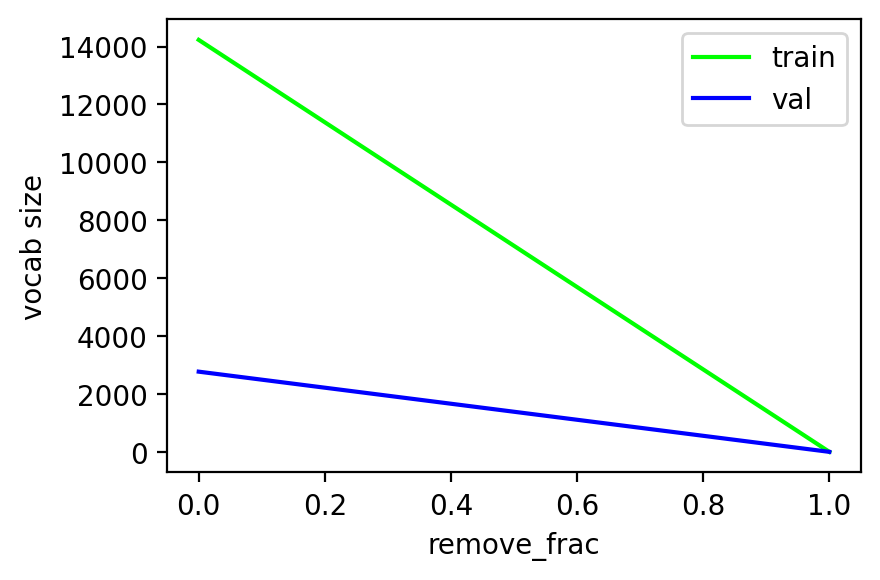

In [12]:
min_freq_for_remove_frac = 10  # change this accordingly

fig1, ax1 = plt.subplots(1, 1, figsize=(4.5, 3))
fig2, ax2 = plt.subplots(1, 1, figsize=(4.5, 3))
for split, color in zip(["train", "val"], ["lime", "b"]):
    text_data = chain(*hf_dataset[split]["text"])
    token_freqs = Counter(text_data)
    freq_vals = list(token_freqs.values())
    freq_vals_dict = {min_freq: len([freq for freq in freq_vals if freq >= min_freq]) for min_freq in range(1, 101)}

    freq_df = pd.DataFrame({"min_freq": freq_vals_dict.keys(), "vocab size (log scale)": freq_vals_dict.values()})
    sns.lineplot(freq_df, x="min_freq", y="vocab size (log scale)", ax=ax1, label=split, color=color)
    ax1.set(yscale="log")
    ax1.legend()

    freq_vals = [freq for freq in freq_vals if freq >= int(min_freq_for_remove_frac)]
    top_tokens = sorted(freq_vals, reverse=True)
    top_tokens_dict = {i: len(top_tokens) - int(i * len(top_tokens)) for i in np.arange(0.0, 1.1, 0.1)}
    top_tokens_df = pd.DataFrame({"remove_frac": top_tokens_dict.keys(), "vocab size": top_tokens_dict.values()})
    sns.lineplot(top_tokens_df, x="remove_frac", y="vocab size", ax=ax2, label=split, color=color)
    ax2.legend()
plt.tight_layout()
plt.show()

---

<font color="orange">__Q1.1.1__ In less than three sentences, describe the effect of changing `min_freq` and `remove_frac` on the vocabulary size. How should one go about setting these two hyperparameters? <br/>
_Hint. Think about what "type" of tokens get removed by increasing the associated hyperparameters._
</font>

Increasing min_freq raises the threshold for token inclusion so that only tokens appearing at least that many times are retained, thereby filtering out infrequent (and often noisy) tokens. Increasing remove_frac further reduces the vocabulary size by discarding a specified fraction of the least frequent tokens among those that met the min_freq criteria; thus, one should set these hyperparameters based on a trade-off between eliminating noise and retaining rare but potentially useful tokens for the task.

__Answer.__

---

Let's setup a few paths! For convenience, we will redirect all the output artefacts to the `cs4740-hw2/artefacts` directory—this includes processed dataset, tokenizer files, experimental artefacts (configs, saved checkpoints, trained models, etc.), submission zip files, etc.

From your criteria above, pick out "reasonable" values for `min_freq` and `remove_frac` (this isn't exact science). Finally, let's train our tokenizer on the training data using these chosen hyperparameters. Set these hyperparameter values below and run the following cell to train a tokenizer which will be saved in `cs4740-hw2/artefacts/tokenizer` folder.

In [13]:
# Change the following two cells with appropriate hyperparameters.
min_freq = 5
remove_frac = 0.3

In [14]:
!python -m scripts.train_tokenizer \
    --config-path={os.path.join(CONFIGS_DIR, "train_tokenizer.yml")} \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --filepath-to-store-tokenizer={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --min-freq={min_freq} \
    --remove-frac={remove_frac}

In [15]:
tokenizer = Tokenizer()
tokenizer.from_file(os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json"))
print(tokenizer)

Tokenizer(vocab_size=16836, pad_token=<|pad|>, unk_token=<|unk|>, lowercase=False)


<a name="sec12"></a>
#### [1.2] Data collation <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `ner/data_processing/data_collator.py`.

Before we begin, it might be worth reading about batching for neural networks; there are excellent blog posts online; for a quick recap, see: https://stats.stackexchange.com/a/153535.

Recall that padding is necessary (in most cases) for batching. When it comes to padding, there are two common approaches: static padding and dynamic padding. Static padding pads each sentence in the dataset to the same length, while dynamic padding deals with the data in batches and pads to the longest sentence in a given batch.

In this assignment, we will be using dynamic padding instead of static padding. You can run the code cell below to view a distribution of sequence lengths in the train and val data splits.

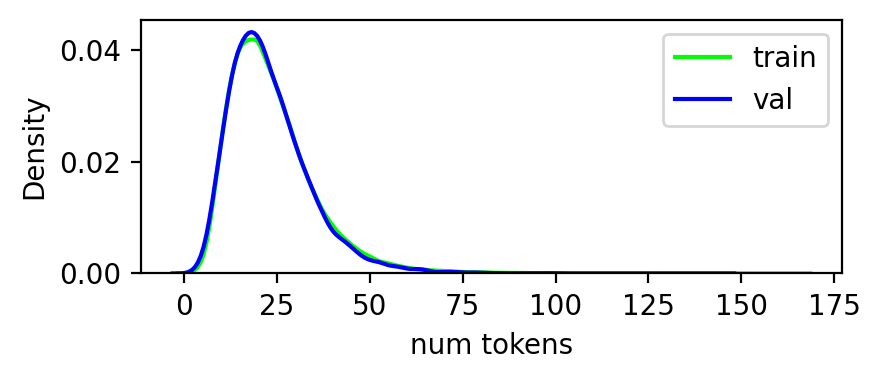

In [16]:
hf_dataset = hf_dataset.map(lambda data_instance: {"seq_length": len(data_instance["text"])}, batched=False)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 2))
for split, color in zip(["train", "val"], ["lime", "b"]):
    sns.kdeplot(hf_dataset[split]["seq_length"], ax=ax, label=split, color=color)
    ax.set(xlabel="num tokens")
    ax.legend()
plt.tight_layout()
plt.show()

---
<font color="orange">__Q1.2.1__ Following our data distribution, (in under three sentences,) explain why is dynamic padding better than static padding? <br/>
_Hint. Use the plot above to make observations about varying sequence lengths._
</font>

From the distribution, most sequences are relatively short (around 20–40 tokens), but there is a long tail extending beyond 100 tokens. Static padding would require padding all sequences to the maximum length of 75, which would waste a lot of space for the majority of short examples. Dynamic padding, by only padding to the longest sequence in each batch, saves memory and speeds up training.

__Answer.__

---

__Let's dynamically pad!__

We will be filling out the `__call__` method of `DataCollator` class in `ner/data_processing/data_collator.py` file (marked with <font color="orange">`TODO-1.2-1`</font>). For those interested, the `__call__` will be similar in function to PyTorch's [`collate_fn`](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn). We want to dynamically pad our batches to the batch max length—we'll use the approach of: 1) see one sample at a time, 2) (if needed,) pad to batch max length, and 3) append the padded tensor to an iterable.

First, let's create the iterable in "append to an iterable": you can instantiate empty tensors (using [`torch.empty`](https://pytorch.org/docs/stable/generated/torch.empty.html)) to represent the `input_ids` and `padding_mask` for the batch. The dimensions of the empty tensors must be `(batch_size, batch_max_length)` where `batch_size` is the number of sequences in the batch, and `batch_max_length` is the length of the longest sequence in the batch, which can be obtained using `self._get_max_length()`.

> __Note.__ When data instances are passed to the `__call__` method, the data instances include "text" [= `self.text_colname`], "index", and "NER" fields for train, val data, while the "test" split does _not_ include "NER" field [= `self.label_colname`]. We need to handle this!—if the data instance contains `self.label_colname`, then create an additional empty tensor for labels.

Next, you can use the tokenizer (accessible via `self.tokenizer`) to tokenize your data. The tokenizer returns `input_ids` and `padding_mask`, which you can store in appropriate empty tensors created before. It is important that you check the shapes of tensors you're appending (you may find [`torch.squeeze`](https://pytorch.org/docs/stable/generated/torch.squeeze.html) helpful to squash any unwanted dimensions).

Finally, if the data comes with labels, we'll need to add `PAD_NER_TAG` to the labels wherever the associated token is a padding token. Recall that "$1$" in the `padding_mask` represents a padding token; to check if the data is padded is you can use [`torch.sum`](https://pytorch.org/docs/stable/generated/torch.sum.html). Here's an example to illustrate the same:

> padded tokens: ["I", "am", "Naruto", "Uzumaki", `PAD_TOKEN`, `PAD_TOKEN`] <br/>
> input IDs: [2, 3, 4, 1, 0, 0] <br/>
> padding mask: [0, 0, 0, 0, 1, 1] <br/>
> padded labels: ["O", "O", "B-PER", "I-PER", `PAD_NER_TAG`, `PAD_NER_TAG`]

Similarly, the data might be truncated, in which case, you will have to truncate the labels as well. (Pay special attention to `self.padding_side` and `self.truncation_side`.)

Return the results as a dictionary with (strings) `"input_ids"`, `"padding_mask"`, and `"labels"` (if present) as keys and associated aggregated tensors as values. Use the cell below to test if your data collator runs as expected; check the shapes of returned tensors (and anything you can think of) are as expected.

In [17]:
from ner.data_processing.constants import PAD_NER_TAG
from ner.data_processing.data_collator import DataCollator

data_instances = [
    {"text": ["this", "is", "hello"], "NER": ["O", "O", "B-PER"]},
    {"text": ["the", "cycle", "is", "there"], "NER": ["O", "B-MISC", "O", "O"]},
]

data_collator = DataCollator(
    tokenizer=tokenizer,
    padding="longest",
    max_length=None,
    padding_side="right",
    truncation_side="right",
    pad_tag=PAD_NER_TAG,
    text_colname="text",
    label_colname="NER",
)
data_collator(data_instances)
# Test shapes of tensors in the returned dictionary.

{'input_ids': tensor([[  49,   13,    1,    0],
         [   2, 2504,   13,  107]]),
 'padding_mask': tensor([[0, 0, 0, 1],
         [0, 0, 0, 0]]),
 'labels': tensor([[   0,    0,    3, -100],
         [   0,    7,    0,    0]])}

<a name="sec2"></a>
### [2] Embeddings <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `ner/nn/embeddings/embedding.py`.

Let's first create our `TokenEmbedding` layer using [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html); we can initialize the weights via [`self.apply`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=apply#torch.nn.Module.apply) and using `self.init_weights` provided in `ner/nn/module.py`, or alternatively use [`torch.nn.init`](https://pytorch.org/docs/master/nn.init.html). Fill out <font color="orange">`TODO-2-1`</font> in the `TokenEmbedding.__init__` accordingly.

> __Tip.__ Notice how all the neural models inherit `ner.nn.module.Module` (note the `super().__init__()` line); it is worth spending time viewing the functionality provided within `ner.nn.module.Module`. One such functionality suggested above is `init_weights()`.

We've gone ahead and created a test embedding for you below, you can test that the shape of the embedding component is as expected. (Another useful `ner.nn.module.Module` method we use below is `print_params()` to view the model parameters.)

In [18]:
from ner.data_processing.constants import PAD_TOKEN
from ner.nn.embeddings.embedding import TokenEmbedding

token_embedding = TokenEmbedding(vocab_size=2, embedding_dim=10, padding_idx=tokenizer.token2id[PAD_TOKEN])
token_embedding.print_params()  # see the model parameters
# Test shapes of token_embedding.* components.

+------------------+------------+---------------+
|      module      | num_params | requires_grad |
+------------------+------------+---------------+
| embedding.weight |     20     |      True     |
+------------------+------------+---------------+
total trainable params: 20


Now that we've initialized our `TokenEmbedding`, let's go ahead and fill in the `forward()` part under <font color="orange">`TODO-2-2`</font>. This takes in the tokenized `input_ids` of `(batch_size, batch_max_length)` and creates embeddings of shape: `(batch_size, batch_max_length, embedding_dim)` out of them, by passing them through the embedding layer. Make sure the dimensions of your input and output tensors are as expected.

Upon completion, you can run the cell below to confirm everything is as expected.

In [19]:
vocab_size = 2
batch_size, batch_max_length = 4, 6

token_embedding = TokenEmbedding(vocab_size=2, embedding_dim=10, padding_idx=tokenizer.token2id[PAD_TOKEN])
input_embeddings = token_embedding(input_ids=torch.randint(0, vocab_size, (batch_size, batch_max_length)))
input_embeddings.shape  # check if the shape matches to that intended

torch.Size([4, 6, 10])

---

<a name="sec3"></a>
### [3] The training, evaluation loop <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `ner/trainers/trainer.py`.</font>

In this section, we will implement functionality to train and evaluate any neural network [= FFNN, RNN in our case]. Before we begin, observe the loss function used in `Trainer.__init__` to be [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).


---

<font color="orange">__Q3.1.__ What is the difference between [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)? What implication does using `nn.CrossEntropyLoss` have on the use of [`nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) before passing the logits to `nn.CrossEntropyLoss`? (Explain in under three sentences.)
</font>

__Answer.__

nn.CrossEntropyLoss combines a log softmax and negative log likelihood loss in one function, meaning it expects raw logits and applies the necessary transformation internally, whereas nn.NLLLoss expects log probabilities as input. Therefore, when using nn.CrossEntropyLoss, you should not apply nn.Softmax (or log softmax) before passing the logits, as doing so would effectively double-apply the softmax operation and could lead to incorrect loss values.

__Training__

Let's implement the `_train_epoch()` method in the `Trainer` class (fill out <font color="orange">`TODO-3-1`</font>). This is a standard training loop, where a batch consists of `input_ids`, `padding_mask`, and `labels` processed by the `DataCollator`.

> __Tip.__ In PyTorch, all tensors are expected to be on the same device, this means that the `self.model` and `input_ids` must be on the same device. Devide here can mean `'cpu'` or `'cuda'` (gpu). If you have multiple gpus available (possibly not relevant for this assignment), you can specify using `'cuda:0'` or `'cuda:1'`, where 0/1 is the index of the gpu.  You can set `self.device` for the `Trainer` class at initialization, and then use `x.to(self.device)` in any function in the `Trainer` class to move a tensor `x` to a desired device.

Before we start, set the model to `train` mode (why?). We'll loop over batches of the dataloader, and for each batch:
* zero-out the gradient,
* noting that the input to a model is just `input_ids`, get predictions from a given model (use `self.model(input_ids)`; use appropriate device mapping),
* compute the loss using the model predictions and labels; you can use `compute_loss()` from `ner.utils.metrics` (the function is already imported in the `Trainer` file),
* backpropagate the loss,
* drop all intermediate buffers that are unwanted by calling [`.item()`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html) on the loss—we leave it as a self-exercise for you to explore why this step is needed,
* [clip the gradient norm](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using `self.grad_clip_max_norm` as the norm value; you can read about the implications of "exploding" gradients,
* update the model parameters, and
* compute batch-level metrics (we will average metrics across all batches to compute the overall performance).

(For the last step above,) use the following code in `_train_epoch()` to generate appropriate metrics for the current batch, and to append the computed metrics to the `metrics` local variable (dictionary):

```python
# Compute metrics for a given batch.
batch_metrics = compute_metrics(
    preds=preds,
    labels=batch["labels"],
    padding_mask=batch["padding_mask"],
    other_ner_tag_idx=self.other_ner_tag_idx,
    average="weighted",
)
# Append batch-level metrics to `metrics` local variable.
for key in metrics:
    metrics[key].append(batch_metrics[key]) if key != "loss" else metrics[key].append(loss)
```

Let's test to see if everything runs as expected (we'll use the previously created `TokenEmbedding` as a stub for our "model"). Don't worry about the performance, it's just to ensure that everything "runs".


In [20]:
from torch.optim import AdamW
from torch.utils.data import DataLoader

from ner.data_processing.constants import NER_ENCODING_MAP
from ner.data_processing.constants import PAD_TOKEN
from ner.trainers.trainer import Trainer

data_instances = datasets.Dataset.from_dict(
    {
        "text": [["Hello", "my", "friend"], ["My", "name", "is", "Naruto", "Uzumaki"], ["I", "am", "Shisui"]],
        "NER": [["O", "O", "O"], ["O", "O", "O", "B-PER", "I-PER"], ["O", "O", "B-PER"]],
        "index": [[19, 20, 21], [2, 3, 4, 5, 6], [11, 12, 13]],
    }
)
data_collator = DataCollator(
    tokenizer=tokenizer,
    padding="longest",
    max_length=None,
    padding_side="right",
    truncation_side="right",
    pad_tag=PAD_NER_TAG,
    text_colname="text",
    label_colname="NER",
)
dataloader = DataLoader(data_instances, collate_fn=data_collator, batch_size=1)

token_embedding = TokenEmbedding(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=(len(NER_ENCODING_MAP.keys()) - 1),
    padding_idx=tokenizer.token2id[PAD_TOKEN],
)

optimizer = AdamW(token_embedding.parameters())
trainer = Trainer(model=token_embedding, optimizer=optimizer, data_collator=data_collator, train_data=data_instances)
trainer._train_epoch(dataloader)

/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device

{'loss': np.float64(2.199944019317627),
 'precision': np.float64(nan),
 'recall': np.float64(nan),
 'accuracy': np.float64(nan),
 'f1': np.float64(nan),
 'entity_f1': np.float64(0.0)}

__Evaluation__

Now let's implement the `_eval_epoch()` method in the `Trainer` class (fill out <font color="orange">`TODO-3-2`</font>). This is a standard evaluation loop, where a batch consists of `input_ids`, `padding_mask`, and `labels` processed by the `DataCollator`.

---
<font color="orange">__Q3.2.__ Before proceeding, observe the `@torch.no_grad()` annotation on `Trainer._eval_epoch()`—why are we using "no grad" at evaluation? (Explain in under three sentences.)
</font>

__Answer.__

Using torch.no_grad() during evaluation prevents gradient computations, which aren't needed when simply making predictions and computing metrics. This results in lower memory usage and faster computation since the framework doesn't have to track operations for backpropagation. Additionally, it helps avoid potential side effects from inadvertently updating the computation graph during evaluation.

Before we implement `_eval_epoch()`, set the model to `eval` mode (why?). We'll loop over batches of the dataloader, and for each batch:
* noting that the input to a model is just `input_ids`, get predictions from a given model (use `self.model(input_ids)`; use appropriate device mapping),
* compute the loss using the model predictions and labels; you can use `compute_loss()` from `ner.utils.metrics` (the function is already imported in the `Trainer` file),
* use [`.item()`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html) on the loss to drop all intermediate buffers, and
* compute batch-level metrics (we will average metrics across all batches to compute the overall performance).

You can reuse the code above to generate appropriate metrics for the current batch, and to append the computed metrics to the `metrics` local variable (dictionary). Let's use the same stubbing as before to ensure everything runs as expected.

> __Tip.__ An easy thing to check (and note) is that evaluation should take lesser time than training!

In [21]:
from torch.optim import AdamW
from torch.utils.data import DataLoader

from ner.data_processing.constants import NER_ENCODING_MAP
from ner.data_processing.constants import PAD_TOKEN
from ner.trainers.trainer import Trainer

data_instances = datasets.Dataset.from_dict(
    {
        "text": [["Hello", "my", "friend"], ["My", "name", "is", "Naruto", "Uzumaki"], ["I", "am", "Shisui"]],
        "NER": [["O", "O", "O"], ["O", "O", "O", "B-PER", "I-PER"], ["O", "O", "B-PER"]],
        "index": [[19, 20, 21], [2, 3, 4, 5, 6], [11, 12, 13]],
    }
)
data_collator = DataCollator(
    tokenizer=tokenizer,
    padding="longest",
    max_length=None,
    padding_side="right",
    truncation_side="right",
    pad_tag=PAD_NER_TAG,
    text_colname="text",
    label_colname="NER",
)
dataloader = DataLoader(data_instances, collate_fn=data_collator, batch_size=1)

token_embedding = TokenEmbedding(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=(len(NER_ENCODING_MAP.keys()) - 1),
    padding_idx=tokenizer.token2id[PAD_TOKEN],
)

optimizer = AdamW(token_embedding.parameters())
trainer = Trainer(model=token_embedding, optimizer=optimizer, data_collator=data_collator, train_data=data_instances)
trainer._eval_epoch(dataloader)

/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device

{'loss': np.float64(2.1988547643025718),
 'precision': np.float64(nan),
 'recall': np.float64(nan),
 'accuracy': np.float64(nan),
 'f1': np.float64(nan),
 'entity_f1': np.float64(0.0)}

---

<a name="milestone"></a>
### [$\ast$] Milestone submission <small>[↩︎](#outline)</small>

Run the following cell to make a milestone submission. The `make_submission` command when run with `--milestone-submission` flag creates a `milestone_submission.zip` file in `cs4740-hw2/artefacts` folder, which is to be submitted on the submission site(s).  <font color="red">Caution: the script will overwrite any file named `milestone_submission.zip` existing in `cs4740-hw2/artefacts` folder.</font>

The `milestone_submission.zip` is all that you will need to submit for the milestone (no need to submit anything else!).

In [22]:
submission_filepath = f"{ARTEFACTS_DIR}"

!python -m scripts.make_submission \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --tokenizer-filepath={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --basepath-to-store-submission={os.path.join(ARTEFACTS_DIR, submission_filepath)} \
    --net-ids={net_ids} \
    --milestone-submission

if os.path.isfile(f"{os.path.join(ARTEFACTS_DIR, 'milestone_submission.zip')}"):
    display(success())
else:
    print(colored("Oops, something went wrong!", "red"))

submission stored at: /content/drive/MyDrive/cs4740_hw2/hw2-release/artefacts/milestone_submission.zip



---

<a name="sec4"></a>
### [4] FFNNs <small>[↩︎](#outline)</small>

In this section, you will implement and train a Feed Forward Neural Network (FFNN) to classify tokens into appropriate named-entities. (Contrasting FFNN to an RNN,) FFNNs are _parallel_ processors—they can process an entire sequence in one go! Let's look at how an FFNN processes a single token:

<div align="center">
    <img src="https://i.imgur.com/jERkG7r.png" width="240"/>
    <br/>
    <b>Fig. 1.</b> Forward pass of a single token through a single hidden-layer [= one pink layer in the middle!] FFNN
    <br/>
    $x_k^{(j)}$, $z_k^{(i)}$, $y_k^{(l)}$ indicate the $j$-th embedding, $i$-th hidden, and $l$-th output dimensions associated with the $k$-th input token
    <br/>
    (Adapted from: <a href="https://tikz.net/neural_networks/">TikZ.net</a>)
</div>

The FFNN processes a sequence of $L$ tokens, where each token $x_k \in \mathbb{R}^d$ gets mapped to the hidden dimension $\mathbb{R}^h$ through a linear transformation:
$$
z_k = f(W x_k + b_W),
$$

where $W \in \mathbb{R}^{h \times d}$ and $b_W \in \mathbb{R}^h$ are the weights and biases associated with the transformation, $z_k \in \mathbb{R}^h$ is the hidden intermediate, and $f(\cdot)$ is some nonlinearity applied element-wise. In practice, these computations are all "matrixified":
$$
Z = f(\mathrm{X} \mathrm{W}^T) \equiv f(Z'),
$$

where $Z \in \mathbb{R}^{L \times h}$, $\mathrm{X} \in \mathbb{R}^{L \times d+1}$ (often known as the design matrix) is the matrix of input token embeddings with a column of ones appended at the end, and $\mathrm{W} \in \mathbb{R}^{h \times d+1}$ (upright-$\mathrm{W}$, not slanted-$W$) is the weight matrix with bias vector absorbed as the last column of the matrix. $\mathrm{W}$ is learned through backpropagation [= the training loop in [section 3](#sec3)].


> __Notation.__ From hereon, we use the notation "upright-$\mathrm{M}$" (or simply "$\mathrm{M}$") to indicate that (1) if (slanted-)$M$ is a _weight_ matrix, then the bias is absorbed into the matrix, or (2) if (slanted-)$M$ is a _design_ matrix, then a column of ones has been appended to the matrix.



A similar reasoning follows the hidden-to-output mapping, resulting in:
$$
Y = g(\mathrm{Z} \mathrm{V}^T) \equiv g(Y'),
$$
where $Y \in \mathbb{R}^{L \times o}$, upright-$\mathrm{Z} \in \mathbb{R}^{L \times h+1}$, and upright-$\mathrm{V} \in \mathbb{R}^{o \times h+1}$, $g(\cdot)$ is an element-wise nonlinearity, which is a softmax function for classification problems. Also, the row vectors of $Y'$ are what is often referred to as "_unnormalized_ logits", i.e., predictions before they are passed through a softmax/sigmoid.


One final note: A "quirk" of PyTorch is that you never have to explicitly form upright-$\mathrm{X}$ (or upright-$\mathrm{Z}$); PyTorch does this for you! For example, an `nn.Linear` (equivalent to upright-$\mathrm{M}$) transforms slanted-$A$ (with some dimensions) into slanted-$B$ of appropriate dimensions.

<a name="sec41"></a>

#### [4.1] Single-layer FFNN <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `ner/nn/models/ffnn.py`.</font>

In this section, we will implement a simple, single-layer FFNN. For this part of the implementation, we will "forget" about the existence of `num_layers` (for convenience, we set `num_layers = 1` in the FFNN class constructor).

__Initializing the FFNN__

Let's implement the `__init__` of our `FFNN` class based on how FFNNs are mathematically represented. To this end,
* we need $\mathrm{W}$, $\mathrm{V}$, each implemented as [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) such that $\mathrm{W}: X$ → $Z$ and $\mathrm{V}: Z$ → $Y$—this needs to be filled in by you, under <font color="orange">`TODO-4-1`</font>,
* a nonlinearity $f(\cdot)$—we'll be using [nonlinearities available in `torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions) (specifically, `F.relu`) and directly applying them as needed when we implement the `forward()` part—let's ignore [= don't include it in `__init__`] this part for now!, and
* weight initialization of the transformation matrices: already implemented using `self.apply(self.init_weights)`.

Feel free to test that your initialization runs as expected in the cell below—we've gone ahead and created a test FFNN for you, you can check if the shapes of the model components are as expected.

In [42]:
from ner.nn.models.ffnn import FFNN

ffnn = FFNN(embedding_dim=10, hidden_dim=5, output_dim=2)
# Test shapes of ffnn.* components.

__The forward pass__

Now that we've successfully initialized the FFNN, let's try to run a `forward()` pass through the network. What does this entail?:
* using $\mathrm{W}$, transform the input $X$ of shape `(batch_size, batch_max_length, embedding_dim)` to $Z' = \mathrm{XW}^T$, which is the hidden intermediate,
* apply a nonlinearity [`F.relu`](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu) on the hidden intermediate (don't use any other nonlinearity), and
* using $\mathrm{V}$, transform the hidden intermediate $Z$ to $Y' = \mathrm{ZV}^T$ of shape `(batch_size, batch_max_length, output_dim)`.

We would normally apply a softmax over $Y'$ such that $Y = \text{softmax}(Y')$; however, revisit Q3.1 to note if this is needed. With this in mind, fill out the <font color="orange">`TODO-4-2`</font> part in the `forward()` method to run a forward pass.

Upon completion, you can run the cell below to train your FFNN! Change the `batch_size` and `num_epochs` below as you see fit; all other hyperparameters (e.g., `embedding_dim`, `hidden_dim`, etc.) are present in `scripts/configs/train_model.yml`—you're free to change these as well. Again, don't worry too much about the performance—the following is just a test run. (The model artefacts are stored under `<experiment-name>` subfolder of `cs4740-hw2/artefacts/experiments` folder.)

> __Training time.__ With a batch size of $128$, training a single-layered FFNN for one epoch on a Colab CPU takes about ~$6$mins, while on a Colab T4 GPU it takes ~$1.5$mins. Owing to hardware limitations, we do not recommend increasing the batch size beyond $128$.

In [43]:
# Set the batch size and number of training epochs.
batch_size = 128
num_epochs = 10 # number of loops over dataset

In [44]:
model_type = "ffnn"
num_layers = 1

experiment_name = f"model={model_type}_layers={num_layers}_batch={batch_size}"

!python -m scripts.train_model \
    --config-path={os.path.join(CONFIGS_DIR, "train_model.yml")} \
    --tokenizer-config-path={os.path.join(CONFIGS_DIR, "train_tokenizer.yml")} \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --tokenizer-filepath={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --model-type={model_type} \
    --num-layers={num_layers} \
    --batch-size={batch_size} \
    --num-epochs={num_epochs} \
    --basepath-to-store-results={os.path.join(ARTEFACTS_DIR, "experiments")} \
    --experiment-name={experiment_name}

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), ra

From the saved checkpoints, let's load the best model (if your `num_epochs` was more than one, else the best model is the only model) based on the `entity_f1` validation performance logged above; set the `best_epoch` below to reflect the epoch (zero-indexed) that resulted in the best model.

> __Tip.__ Check out the files stored in the `cs4740-hw2/artefacts/experiments` folder; there are quite a few important files stored there, including the training metrics, validation metrics, model checkpoints (one per epoch), etc.

In [45]:
# Change the best epoch value.
best_epoch = 7

In [46]:
config_path = os.path.join(ARTEFACTS_DIR, f"experiments/{experiment_name}/config.json")
with open(config_path, "r") as fp:
    config = yaml.safe_load(fp)

checkpoint_filename = f"experiments/{experiment_name}/checkpoints/checkpoint_{best_epoch}.ckpt"
model = NERPredictor(
    vocab_size=tokenizer.vocab_size,
    padding_idx=tokenizer.token2id[tokenizer.pad_token],
    output_dim=len(NER_ENCODING_MAP) - 1,
    **config["model"],
)
checkpoint = torch.load(os.path.join(ARTEFACTS_DIR, checkpoint_filename), map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
model.print_params()

+----------------------------+------------+---------------+
|           module           | num_params | requires_grad |
+----------------------------+------------+---------------+
| embedding.embedding.weight |  5050800   |      True     |
| model.input_hidden.weight  |   153600   |      True     |
|  model.input_hidden.bias   |    512     |      True     |
| model.hidden_output.weight |    4608    |      True     |
|  model.hidden_output.bias  |     9      |      True     |
+----------------------------+------------+---------------+
total trainable params: 5.21M


Let's see how well our single-layer learned model performs on unseen data; running the cell below shows the model's predictions for a chosen sample (change the `sample_idx` value to retrieve a different sample).

In [47]:
partition, sample_idx = "val", 7
labels = hf_dataset[partition][sample_idx]["NER"] if "NER" in hf_dataset[partition][sample_idx] else None
_ = inspect_preds(tokenizer=tokenizer, model=model, text=hf_dataset[partition][sample_idx]["text"], labels=labels)

Convention: [when labels are provided,] dark green text indicates that the true label and predicted 
label match exactly, including the BIO tagging (e.g., pred = 'B-PER', true = 'B-PER'); green text 
indicates an entity match between true and predicted labels but not the BIO tagging (e.g., pred = 
'B-PER', true = 'I-PER'); red text indicates that predicted and true labels mismatch (e.g., pred = 
'B-PER', true = 'I-LOC').

    token    is-unk?  pred  true
--- -------  -------  ----  ----
0   A                 O     O   
1   world             O     O   
2   record            O     O   
3   price             O     O   
4   of                O     O   
5   £                 O     O   
6   1.24     ✓        O     O   
7   "                 O     O   
8   million           O     O   
9   was               O     O   
10  set               O     O   
11  by                O     O   
12  a                 O     O   
13  Fabergé  ✓        O     B-PER
14  clock             O     O   
15  .       

<a name="sec42"></a>

#### [4.2] Multi-layered FFNN <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `ner/nn/models/ffnn.py` (same file used in [section 4.1](#sec41)).</font>

Yay! Congrats on running your first FFNN! Now, let's go back and adapt our single-layered FFNN into a multi-layered FFNN. <font color="red">This is the implementation that you'll be submitting to us (not the single-layered implementation).</font>

__Accommodating multiple layers at initialization__

In our first attempt, we initialized such that we project to and from a single hidden layer; we now wish to support an arbitrary number of hidden layers corresponding to `num_layers`. Let's modify the `__init__` of our `FFNN` class to accommodate this. How?:
* we still need $\mathrm{W}: X$ → $Z_1$ ($Z_1$ indicates the first hidden layer), so let's retain $\mathrm{W}$,
* we also need $\mathrm{V}: Z_n$ → $Y$ ($Z_n$ indicates the last hidden layer), so let's also retain $\mathrm{V}$,
* when `num_layers` is greater than one, we need an appropriate number of weight matrices, $\mathrm{U}_k$s, such that $\mathrm{U}_k: Z_k$ → $Z_{k+1}$; these are mappings from hidden dimension $\mathbb{R}^h$ to hidden dimension $\mathbb{R}^h$—each $\mathrm{U}_k$ can be implemented as [`nn.Linear`](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Fgenerated%2Ftorch.nn.Linear.html) and the list of all $\mathrm{U}_k$s can be maintained using an [`nn.ModuleList`](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Fgenerated%2Ftorch.nn.ModuleList.html) (why is an `nn.ModuleList` used instead of just maintaining a list of `nn.Linear`s?; we leave this as a self-exercise).

With these changes, your FFNN should initialize one input layer, one output layer, and `num_layers`-many hidden layers. Upon completion, run the cell below to see if the model parameters are as expected.

In [48]:
ffnn = FFNN(embedding_dim=10, hidden_dim=5, output_dim=2, num_layers=5)
ffnn.print_params()

+------------------------+------------+---------------+
|         module         | num_params | requires_grad |
+------------------------+------------+---------------+
|  input_hidden.weight   |     50     |      True     |
|   input_hidden.bias    |     5      |      True     |
| hidden_layers.0.weight |     25     |      True     |
|  hidden_layers.0.bias  |     5      |      True     |
| hidden_layers.1.weight |     25     |      True     |
|  hidden_layers.1.bias  |     5      |      True     |
| hidden_layers.2.weight |     25     |      True     |
|  hidden_layers.2.bias  |     5      |      True     |
| hidden_layers.3.weight |     25     |      True     |
|  hidden_layers.3.bias  |     5      |      True     |
|  hidden_output.weight  |     10     |      True     |
|   hidden_output.bias   |     2      |      True     |
+------------------------+------------+---------------+
total trainable params: 187


__The forward pass, take-2!__

Now that we have successfully initialized our FFNN to support multiple layers, we need to update the FFNN's `forward()` method to forward propagate through _all_ of the hidden layers (not just the first one!). What does this look like?:
* using $\mathrm{W}$, transform the input $X$ to $Z'_1 = \mathrm{XW}^T$, which is the first hidden intermediate, and applying a nonlinearity [`F.relu`](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu) on the first hidden intermediate—we've already completed this in [section 4.1](#sec41)!,
* for each $\mathrm{U}_k$ ($k > 1$), we need to compute $Z'_{k} = \mathrm{Z}_{k-1} \mathrm{U}_k^T$ and apply [`F.relu`](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu) on the obtained $Z_k'$—make changes to include this functionality, and finally
* using $\mathrm{V}$, transform the last ($n$-th) hidden intermediate $Z_n$ to $Y' = \mathrm{Z}_n\mathrm{V}^T$—modify the existing code to reflect this.

Again, should we apply a softmax over $Y'$ such that $Y = \text{softmax}(Y')$?

Upon completion, you can run the cell below to train your multi-layered FFNN! Change the `num_layers`, `batch_size`, and `num_epochs` below as you see fit; all other hyperparameters (e.g., `embedding_dim`, `hidden_dim`, etc.) are present in `scripts/configs/train_model.yml`—you're free to change these as well. (The model artefacts are stored under `<experiment-name>` subfolder of `cs4740-hw2/artefacts/experiments` folder.)

> __Training time.__ With a batch size of $128$, training a two-layered FFNN for one epoch on a Colab CPU takes about ~$10$mins, while on a Colab T4 GPU it takes ~$2$mins. Again, owing to hardware limitations, we do not recommend increasing the batch size beyond $128$.

<font color="red">Do not use `num_layers` greater than $2$; using more than two layers causes unwanted out-of-memory errors on our autograder servers.</font> (You are free to experiment with more than two layers, but the models in the final submission __cannot__ have more than two layers.)

In [49]:
# Set the number of layers, batch size, and number of training epochs.
num_layers = 2
batch_size = 128
num_epochs = 10

In [50]:
model_type = "ffnn"

experiment_name = f"model={model_type}_layers={num_layers}_batch={batch_size}"

!python -m scripts.train_model \
    --config-path={os.path.join(CONFIGS_DIR, "train_model.yml")} \
    --tokenizer-config-path={os.path.join(CONFIGS_DIR, "train_tokenizer.yml")} \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --tokenizer-filepath={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --model-type={model_type} \
    --num-layers={num_layers} \
    --batch-size={batch_size} \
    --num-epochs={num_epochs} \
    --basepath-to-store-results={os.path.join(ARTEFACTS_DIR, "experiments")} \
    --experiment-name={experiment_name}

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), ra

Just as before, from the saved checkpoints, let's load the best model (if your `num_epochs` was more than one, else the best model is the only model) based on the `entity_f1` validation performance logged above; set the `best_epoch` below to reflect the epoch (zero-indexed) that resulted in the best model.

> __Tip.__ Think you should've run for more epochs? Fret not, we've got you!—our `train_model.py` script has a parameter `--pretrained-checkpoint-or-model-filepath` that let's you use a pretrained checkpoint .ckpt or pretrained model .pt and continue training. (Check out the documentation website for more specifics.)

In [51]:
# Change the best epoch value.
best_epoch = 9

In [52]:
config_path = os.path.join(ARTEFACTS_DIR, f"experiments/{experiment_name}/config.json")
with open(config_path, "r") as fp:
    config = yaml.safe_load(fp)

checkpoint_filename = f"experiments/{experiment_name}/checkpoints/checkpoint_{best_epoch}.ckpt"
model = NERPredictor(
    vocab_size=tokenizer.vocab_size,
    padding_idx=tokenizer.token2id[tokenizer.pad_token],
    output_dim=len(NER_ENCODING_MAP) - 1,
    **config["model"],
)
checkpoint = torch.load(os.path.join(ARTEFACTS_DIR, checkpoint_filename), map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
model.print_params()

+------------------------------+------------+---------------+
|            module            | num_params | requires_grad |
+------------------------------+------------+---------------+
|  embedding.embedding.weight  |  5050800   |      True     |
|  model.input_hidden.weight   |   153600   |      True     |
|   model.input_hidden.bias    |    512     |      True     |
| model.hidden_layers.0.weight |   262144   |      True     |
|  model.hidden_layers.0.bias  |    512     |      True     |
|  model.hidden_output.weight  |    4608    |      True     |
|   model.hidden_output.bias   |     9      |      True     |
+------------------------------+------------+---------------+
total trainable params: 5.47M


Now let's analyze how well our multi-layer learned model performs on unseen data; running the cell below shows the model's predictions for a chosen sample (change the `sample_idx` value to retrieve a different sample).

In [53]:
partition, sample_idx = "val", 9
labels = hf_dataset[partition][sample_idx]["NER"] if "NER" in hf_dataset[partition][sample_idx] else None
_ = inspect_preds(tokenizer=tokenizer, model=model, text=hf_dataset[partition][sample_idx]["text"], labels=labels)

Convention: [when labels are provided,] dark green text indicates that the true label and predicted 
label match exactly, including the BIO tagging (e.g., pred = 'B-PER', true = 'B-PER'); green text 
indicates an entity match between true and predicted labels but not the BIO tagging (e.g., pred = 
'B-PER', true = 'I-PER'); red text indicates that predicted and true labels mismatch (e.g., pred = 
'B-PER', true = 'I-LOC').

    token      is-unk?  pred   true 
--- ---------  -------  -----  -----
0   The                 O      O    
1   film                O      O    
2   was                 O      O    
3   shot                O      O    
4   in                  O      O    
5   Bhuj       ✓        O      B-LOC
6   and                 O      O    
7   Mumbai              B-LOC  B-LOC
8   with                O      O    
9   brief               O      O    
10  schedules  ✓        O      O    
11  in                  O      O    
12  Bhedaghat  ✓        O      B-LOC
13  (              

Finally, it's often important to understand what the model is looking at when it makes a specific prediction. The easiest way to do this is by looking at the activation values [= outputs from `F.relu`] and see if there are any specific patterns that the model is learning. This is a fairly well-researched area of NLP (and CV), and is often tagged with the keywords: "interpretability" and "explainability".

Set the `module` variable below to visualize the activations of a specific module within your model—use the syntax: `<model-varname>.model.<module-name>` (e.g., `model.model.W` to visualize a layer named `W` in your FFNN named `model`).

Convention: [when labels are provided,] dark green text indicates that the true label and predicted 
label match exactly, including the BIO tagging (e.g., pred = 'B-PER', true = 'B-PER'); green text 
indicates an entity match between true and predicted labels but not the BIO tagging (e.g., pred = 
'B-PER', true = 'I-PER'); red text indicates that predicted and true labels mismatch (e.g., pred = 
'B-PER', true = 'I-LOC').



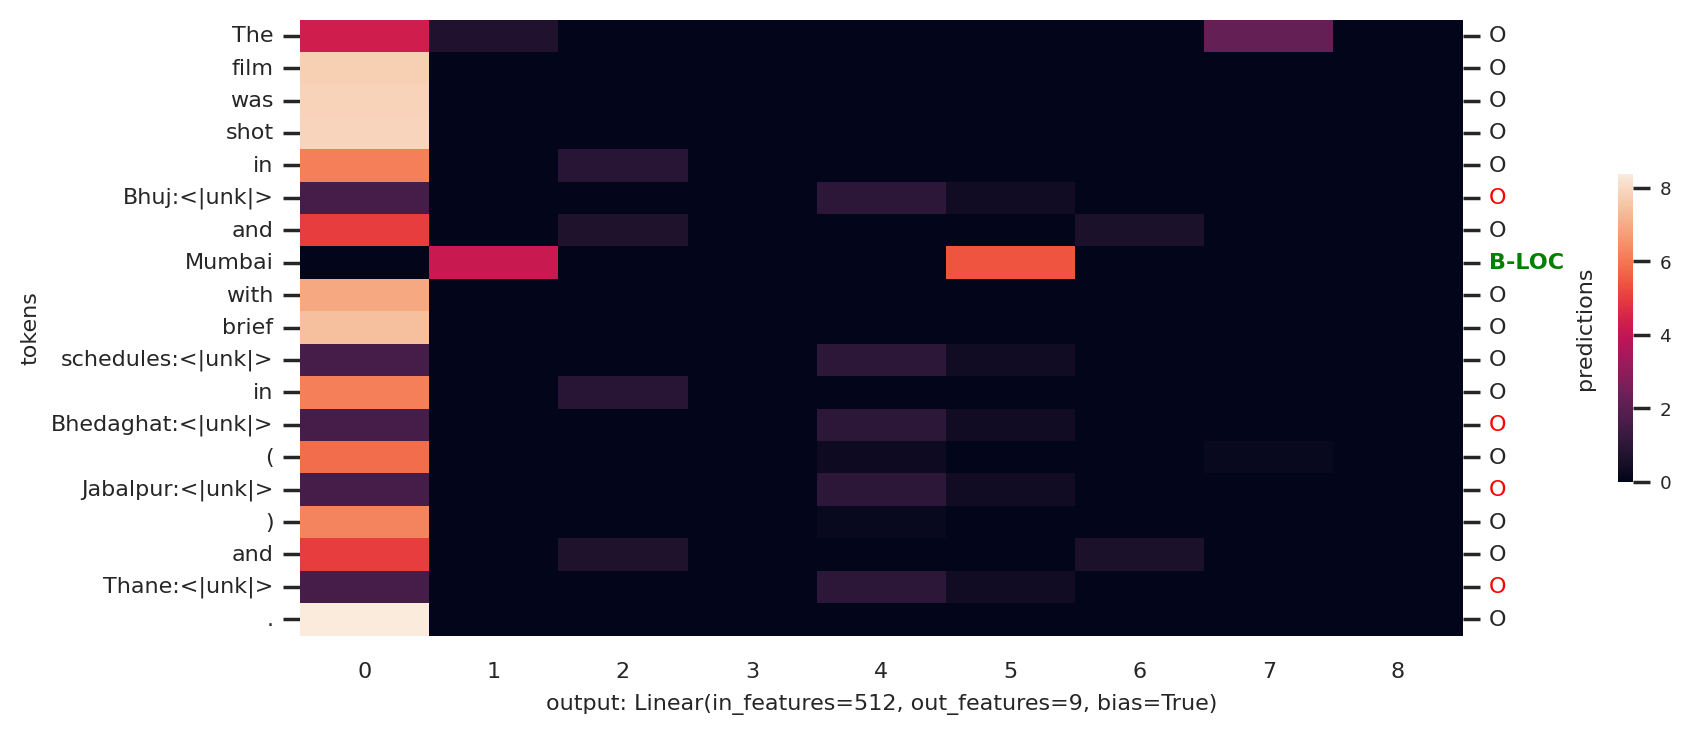

In [54]:
# Set the module you wish to visualize (format: model.model.<module-name>).
module = model.model.hidden_output

visualize_activations(
    tokenizer=tokenizer,
    model=model,
    module=module,
    text=hf_dataset[partition][sample_idx]["text"],
    labels=labels,
    nonlinearity=F.relu,
)

<a name="leaderboard_ffnn"></a>

#### [$\ast$] Leaderboard submission <small>[↩︎](#outline)</small>

> __Note.__ Submitting to the leaderboard is optional, see [<sup>[2]</sup>](#optional) for baselines and related information.

Now that we've trained our FFNN, we can go ahead and make a leaderboard submission. Run the following cells to make a leaderboard submission. The `make_submission` command when run with `--leaderboard-submission` flag creates a `leaderboard_submission.zip` file in `cs4740-hw2/artefacts` folder, which is to be submitted on the submission site. <font color="red">Caution: the script will overwrite any file named `leaderboard_submission.zip` existing in `cs4740-hw2/artefacts` folder.</font>

Set the `ffnn_experiment_name` and `ffnn_best_epoch` accordingly. The `leaderboard_submission.zip` is all that you will need to submit to the leaderboard (no need to submit anything else!).

In [ ]:
# Set the following accordingly.
ffnn_experiment_name = "model=ffnn_layers=2_batch=128"
ffnn_best_epoch = 9

In [ ]:
submission_filepath = f"{ARTEFACTS_DIR}"

ffnn_config_filename =  f"experiments/{ffnn_experiment_name}/config.json"
ffnn_checkpoint_filename = f"experiments/{ffnn_experiment_name}/checkpoints/checkpoint_{ffnn_best_epoch}.ckpt"

!python -m scripts.make_submission \
    --ffnn-config-path={os.path.join(ARTEFACTS_DIR, ffnn_config_filename)} \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --tokenizer-filepath={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --basepath-to-store-submission={os.path.join(ARTEFACTS_DIR, submission_filepath)} \
    --pretrained-ffnn-checkpoint-or-model-filepath={os.path.join(ARTEFACTS_DIR, ffnn_checkpoint_filename)} \
    --leaderboard-submission

if os.path.isfile(f"{os.path.join(ARTEFACTS_DIR, 'leaderboard_submission.zip')}"):
    display(success())
else:
    print(colored("Oops, something went wrong!", "red"))

<a name="sec43"></a>

#### [4.3] Analyzing FFNN <small>[↩︎](#outline)</small>

Please be concise when answer the following questions; brevity is your friend! These questions are to get you thinking about how FFNNs are often designed/experimented with, and are _not_ meant to be an unordered collection of all your thoughts about FFNNs. Make compelling arguments (preferably those that are backed by data) that aren't misleading or confusing.

(All the questions in this section must be answered in under two pages.)

---
<font color="orange">__Q4.3.1.__ In comparison to HMM and MEMM models from the previous assignment, how did your best FFNN model _perform_? Performance is more than just "performance on some metric"; it includes efficiency (e.g., training time), memory (e.g., weights storage), generalizability (e.g., on unknown words), etc. Choose any two dimensions and present your views.
</font>

__Answer.__

**Answer:**

Compared to HMMs/MEMMs, my best FFNN required significantly more training time due to the need for iterative gradient descent across many epochs, whereas HMMs/MEMMs converge relatively quickly with closed-form updates. In addition, the FFNN’s multi-layer architecture demands more memory to store numerous weight matrices, compared to the more compact probabilistic tables of HMMs/MEMMs.

---

<font color="orange">__Q4.3.2.__ We assume that you experimented with some (if not all) hyperparameters. Can you comment on some patterns you observed in hyperparameter tuning—e.g., variations in performance with batch size, number of layers, hidden dimension, embedding dimension, etc. Choose any two hyperparameters.<br/>
(Don't worry!, all your experiments and related metrics are stored in the `cs4740-hw2/artefacts/experiments` folder.)
</font>

__Answer.__


Increasing the batch size from 50 to 128 resulted in more stable gradient estimates and smoother training curves. For example, with a batch size of 128 using an FFNN with 1 layer, the validation entity F1 reached approximately 0.371 at epoch 3, compared to around 0.362 with a batch size of 50. However, larger batches demand more memory and can slow down per epoch updates. Also, comparing one-layer and two-layer FFNNs revealed that adding an extra layer yielded only marginal improvements in performance. In our experiments, a two-layer model achieved training entity F1 scores around 0.457–0.458 and validation entity F1 around 0.367–0.372, which are very similar to the one-layer model’s performance. This suggests that while additional layers can capture more complex patterns, the benefit is slight relative to the increased computational and memory overhead.

---

<font color="orange">__Q4.3.3.__ We provide functionality to visualize activations of the modules of your trained FFNN. See how activations for named-entities vary (when compared to non named-entities) as you pass through the layers of a multi-layered FFNN. Do they get sparser as you get deeper into the network? Or is it the other way around? Maybe there's no specific pattern? <br/>
Don't look for one example where some named entity has a specific pattern and base your answer on that; look for any interesting and general patterns.
</font>

__Answer.__

I noticed several consistent patterns after generating 5 heatmaps. First, tokens labeled as named entities, such as *“Gig\<unk\> Young”* (B-PER), *“Rahman”* (B-PER), or *“Mustique\<unk\>”* (B-LOC), tend to have one or two columns where activation values are significantly higher than the rest. For example, in one heatmap, *“Rahman”* shows a strong orange-to-red band around column 2 or 3, while *“composed”* and *“the”* stay relatively low across all columns.

Second, non-entity tokens, like *“co-starred”*, *“film”*, or filler words such as *“and”*, *“the”*, *“found”*, usually have more moderate or diffuse activations. In multiple heatmaps, these tokens appear as lighter shades spread across columns, indicating that no single neuron strongly activates for them.

Third, the deeper linear layer (shown in some heatmaps as “Linear(in_features=512, out_features=9, bias=True)”) often displays sharper peaks for entity tokens than earlier transformations. For instance, *“Javed\<unk\>”* or *“Akhtar\<unk\>”* in the last heatmap have very bright (dark orange/red) columns for B-PER, whereas nearby words like *“film”* remain dull or pale across all columns.

Lastly, even within the same snippet, if two tokens share the same label but appear in different contexts, their highest activations may cluster around different columns. *“Gig\<unk\> Young”* might show a spike in column 7, while *“Rahman”* lights up column 2, which suggests that the model’s hidden units learn specialized features for distinct contextsm, even if both tokens are ultimately classified as PER.

Overall, these visualizations confirm that named-entity tokens receive stronger, more focused activations, while non-entity tokens remain comparatively low or broadly distributed. The pattern becomes clearer in deeper layers, where only the most relevant features light up for each entity.

---
<a name="sec5"></a>

### [5] RNNs, or "[multilayer machines with loops!](https://direct.mit.edu/books/book/3132/chapter-abstract/85850/Perceptrons-and-Pattern-Recognition)" <small>[↩︎](#outline)</small>

Recurrent Neural Networks (RNNs) are _sequential_ data processors (contrasting to FFNNs, which are parallel processors), capable of retaining information over time [= often thought of as the "memory" of an RNN]. So what does an RNN look like?:

<div align="center">
    <img src="https://i.imgur.com/omdZzRr.png" width="450"/>
    <br/>
    <b>Fig. 2.</b> Compressed (left) and unfolded (right) single-layered RNN
    <br/>
</div>

where $x_t$, $z_t$, and $o_t$ are the input, hidden state, and output at timestep $t$. The recurrent nature of RNNs give us the following "nice" properties:
* the length of the inputs and outputs can be varied (unlike with FFNNs)—this is axiomatically important for language tasks,
* at each timestep $t$, a hidden state $z_t$ maintains a memory of the past and present information [= context], using the previous hidden state $z_{t-1}$ and the input $x_t$, and
* weights $\mathrm{W}$, $\mathrm{U}$, $\mathrm{V}$ are shared across all timesteps!

The RNN above processes a sequence of $L$ tokens [= timesteps] $x_t$s; for input $x_t \in \mathbb{R}^d$, hidden state $z_t \in \mathbb{R}^h$, and output state $o_t \in \mathbb{R}^o$, the RNN learns $W \in \mathbb{R}^{h \times d}$, $U \in \mathbb{R}^{h \times h}$, and $V \in \mathbb{R}^{o \times h}$ via backpropagation through time, such that:
$$
\begin{align*}
z_t &= f(Wx_t + b_W + U z_{t-1} + b_U), \\
y_t &= g(V z_t + b_V) \equiv g(y_t'),
\end{align*}
$$
where $f(\cdot)$ and $g(\cdot)$ indicate element-wise nonlinearity; $g(\cdot)$ is a softmax function in classification tasks. Recall that $y_t'$ is the vector of unnormalized logits.


<a name="sec51"></a>

#### [5.1] Single-layer vanilla RNN <small>[↩︎](#outline)</small>

> <font color="orange">File to be modified: `ner/nn/models/rnn.py`.</font>

In this section, we will implement a simple, single-layered RNN. Just as we did with FFNNs, for this part of the implementation, we will "forget" about the existence of `num_layers` (for convenience, we set `num_layers = 1` in the RNN class constructor).

__Initializing the RNN__

Let's implement the `__init__` part of our `RNN` class to reflect the above. What do we need?:
* the transformation matrices $\mathrm{W}$, $\mathrm{U}$, $\mathrm{V}$, each implemented as [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)—this needs to be filled in by you, under <font color="orange">`TODO-5-1`</font>,
* a nonlinearity $f(\cdot)$: the `nonlinearity_dict` class variable offers three options for nonlinearity, [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU), [`nn.Tanh`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh), and [`nn.PReLU`](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html?highlight=prelu#torch.nn.PReLU); `self.nonlinear` chooses from the `nonlinearity_dict` based on the `nonlinearity` input argument to the class constructor—no need to make any changes here!,
* weight initialization of the transformation matrices: already implemented using `self.apply(self.init_weights)`.

Feel free to test that your initialization runs as expected in the cell below—we've gone ahead and created a test RNN for you, you can check if the shapes of the model components are as expected.

In [23]:
from ner.nn.models.rnn import RNN

rnn = RNN(embedding_dim=10, hidden_dim=5, output_dim=2, bias=True, nonlinearity="tanh")
# Test shapes of rnn.* components.

__The forward pass (and the initial hidden state)__

Now that we've successfully initialized the RNN, let's try to run a `forward()` pass through the network. What does this entail?—we iterate on the _length_ [= time] dimension of the (batched) input embedding of shape `(batch_size, batch_max_length, embedding_dim)`, and at each timestep $t$, we:
* use $\mathrm{W}$ to transform the input $x_t$ to $Wx_t + b_W$,
* use $\mathrm{U}$ to transform the previous hidden state $z_{t-1}$ to $Uz_{t-1} + b_U$,
* compute the current hidden state $z_t = f(Wx_t + b_W + Uz_{t-1} + b_U)$, where $f(\cdot)$ is defined via `self.nonlinear`, and
* use $\mathrm{V}$ to transform the hidden state $z_t$ to output state $y'_t = Vz_t + b_V$ of shape `(batch_size, output_dim)`.

Again, going back to our "Q3.1 thinking" and noting that we are using `nn.CrossEntropyLoss`, should we use a softmax over $y'_t$?

There are two main "hiccups" we haven't dealt with (yet!)—how do we "aggregate" the outputs obtained at each timestep?, and how do we obtain the hidden state $z_0$, for the first timestep?

For output aggregation, special care must be taken to return the output in the expected return type—the return type of the `forward()` method is `torch.Tensor` and not `List[torch.Tensor]`; the final output shape is expected to be `(batch_size, batch_max_length, output_dim)`. There are muliple ways of achieving this, including [`torch.stack`](https://pytorch.org/docs/stable/generated/torch.stack.html), [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html?highlight=cat), etc.

For the initial hidden state, we provide you with a helper `_initial_hidden_states()` function within the `RNN` class that returns (a list of) initial hidden states, provided a batch size and initialization scheme. Let's see what this function returns! (For convenience, let's reuse the RNN class we created above.)

In [24]:
# batch_size = 1, init_zeros = False
initial_hiddens = rnn._initial_hidden_states(batch_size=1, init_zeros=False)
print(f"batch_size = 1, init_zeros = False: {initial_hiddens}")
print(initial_hiddens[0].shape, '\n')

# batch_size = 1, init_zeros = True
initial_hiddens = rnn._initial_hidden_states(batch_size=1, init_zeros=True)
print(f"batch_size = 1, init_zeros = False: {initial_hiddens}")
print(initial_hiddens[0].shape)

batch_size = 1, init_zeros = False: [tensor([ 0.3458,  0.0745,  0.4585, -0.8560, -0.0307])]
torch.Size([5]) 

batch_size = 1, init_zeros = False: [tensor([0., 0., 0., 0., 0.])]
torch.Size([5])


One final note: the initial hidden states output by `_initial_hidden_states()` must be on the same device as the RNN model. With this in mind, fill out the <font color="orange">`TODO-5-2`</font> in the `forward()` method to run a forward pass.

Upon completion, you can run the cell below to train your RNN! Change the `batch_size` and `num_epochs` below as you see fit; all other hyperparameters (e.g., `embedding_dim`, `hidden_dim`, etc.) are present in `scripts/configs/train_model.yml`—you're free to change these as well. Don't worry too much about the performance—the following is simply a test run. (The model artefacts are stored under `<experiment-name>` subfolder of `CS4740/hw2-fa23/artefacts/experiments` folder.)

> __Training time.__ With a batch size of $128$, training a single-layered RNN for one epoch on a Colab CPU takes about ~25mins, while on a Colab T4 GPU it takes ~$2$mins. Owing to hardware limitations, we do not recommend increasing the batch size beyond $128$.

In [25]:
# Set the batch size and number of training epochs.
batch_size = 128
num_epochs = 10

In [26]:
model_type = "rnn"
num_layers = 1

experiment_name = f"model={model_type}_layers={num_layers}_batch={batch_size}"

!python -m scripts.train_model \
    --config-path={os.path.join(CONFIGS_DIR, "train_model.yml")} \
    --tokenizer-config-path={os.path.join(CONFIGS_DIR, "train_tokenizer.yml")} \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --tokenizer-filepath={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --model-type={model_type} \
    --num-layers={num_layers} \
    --batch-size={batch_size} \
    --num-epochs={num_epochs} \
    --basepath-to-store-results={os.path.join(ARTEFACTS_DIR, "experiments")} \
    --experiment-name={experiment_name}

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), ra

Same as before, from the saved checkpoints, let us load the best model (if your `num_epochs` was greater than one, else the best model is the only model) based on the `entity_f1` validation performance logged above; set the `best_epoch` below to reflect the epoch (zero-indexed) that resulted in the best model.

In [27]:
# Change the best epoch value.
best_epoch = 4

In [28]:
config_path = os.path.join(ARTEFACTS_DIR, f"experiments/{experiment_name}/config.json")
with open(config_path, "r") as fp:
    config = yaml.safe_load(fp)

checkpoint_filename = f"experiments/{experiment_name}/checkpoints/checkpoint_{best_epoch}.ckpt"
model = NERPredictor(
    vocab_size=tokenizer.vocab_size,
    padding_idx=tokenizer.token2id[tokenizer.pad_token],
    output_dim=len(NER_ENCODING_MAP) - 1,
    **config["model"],
)
checkpoint = torch.load(os.path.join(ARTEFACTS_DIR, checkpoint_filename), map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
model.print_params()

+----------------------------+------------+---------------+
|           module           | num_params | requires_grad |
+----------------------------+------------+---------------+
| embedding.embedding.weight |  5050800   |      True     |
| model.input_hidden.weight  |   153600   |      True     |
|  model.input_hidden.bias   |    512     |      True     |
| model.hidden_hidden.weight |   262144   |      True     |
|  model.hidden_hidden.bias  |    512     |      True     |
| model.hidden_output.weight |    4608    |      True     |
|  model.hidden_output.bias  |     9      |      True     |
+----------------------------+------------+---------------+
total trainable params: 5.47M


Let's see how well a learned RNN performs on unseen data; running the cell below shows the model's predictions for a chosen sample (change the `sample_idx` value to retrieve a different sample).

In [29]:
partition, sample_idx = "val", 3
labels = hf_dataset[partition][sample_idx]["NER"] if "NER" in hf_dataset[partition][sample_idx] else None
_ = inspect_preds(tokenizer=tokenizer, model=model, text=hf_dataset[partition][sample_idx]["text"], labels=labels)

Convention: [when labels are provided,] dark green text indicates that the true label and predicted 
label match exactly, including the BIO tagging (e.g., pred = 'B-PER', true = 'B-PER'); green text 
indicates an entity match between true and predicted labels but not the BIO tagging (e.g., pred = 
'B-PER', true = 'I-PER'); red text indicates that predicted and true labels mismatch (e.g., pred = 
'B-PER', true = 'I-LOC').

    token       is-unk?  pred    true  
--- ----------  -------  ------  ------
0   She                  O       O     
1   co-starred           O       O     
2   with                 O       O     
3   Richard              B-PER   B-PER 
4   Widmark     ✓        I-PER   I-PER 
5   and                  O       O     
6   Gig         ✓        B-PER   B-PER 
7   Young                I-PER   I-PER 
8   in                   O       O     
9   the                  O       O     
10  romantic             O       O     
11  comedy               O       O     
12  film      

<a name="sec52"></a>

#### [5.2] Multi-layered RNN <small>[↩︎](#outline)</small>

> <font color="orange">File (to be modified): `ner/nn/models/rnn.py` (same file used in [section 5.1](#sec51)).</font>

Congrats on running your first RNN! Now, let's go back and adapt our single-layered vanilla RNN into a multi-layered RNN. <font color="red">This is the implementation that you'll be submitting to us (not the single-layered implementation).</font>

__Accommodating multiple layers at initialization__

In the previous section, we initialized such that we project to and from a single hidden layer; we now wish to support an arbitrary number of hidden layers corresponding to `num_layers`. Note: to keep things simple, we will not be sharing weights across any layers. Let's modify the `__init__` of our RNN class to accommodate this. What do we need to change?:
* we still need $W_1$ to transform $x_t$ for $z_{1,t}$ ($z_{1,t}$ indicates the hidden intermediate at first layer and timestep $t$), so let's retain $\mathrm{W}$ as $\mathrm{W}_1$,
* we need an appropriate number of $\mathrm{W}_k$s ($k > 1$) that transform the current hidden intermediate $z_{k-1,t} \in \mathbb{R}^h$ at layer $k-1$ to an intermediate to be used in layer $k$ at the same timestep $t$—each $\mathrm{W}_k$ can be implemented as [`nn.Linear`](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Fgenerated%2Ftorch.nn.Linear.html) and we'll maintain the list using an [`nn.ModuleList`](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Fgenerated%2Ftorch.nn.ModuleList.html) (same as what we did in multi-layered FFNN),
  * think _vertical_ (in Fig. 2)!: $\mathrm{W}_k$ moves vectors from layer $k-1$ to layer $k$, and
  * when $k = 1$, there is no $\mathrm{W}_{k\,>\,1}$.
* we need an appropriate number of $\mathrm{U}_k$s that transform the previous hidden intermediate $z_{k,t-1}\in \mathbb{R}^h$ at hidden layer $k$ to an intermediate to be used at timestep $t$ in the same layer $k$—each $\mathrm{U}_k$ can be implemented as [`nn.Linear`](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Fgenerated%2Ftorch.nn.Linear.html) and we'll maintain the list using an [`nn.ModuleList`](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Fgenerated%2Ftorch.nn.ModuleList.html),
  * think _horizontal_ (in Fig. 2)!: $\mathrm{U}_k$ is shared across the timesteps of layer $k$, and
  * when $k = 1$, the multi-layered RNN should look exactly like vanilla RNN from [section 5.1](#sec51) with $\mathrm{U}_1$ being vanilla RNN's $\mathrm{U}$.
* we also need $V: z_{n,t}$ → $y_t'$ ($z_{n,t}$ indicates the hidden intermediate from timestep $t$ at the last layer)—let's retain $\mathrm{V}$.

With these changes, your RNN should now accommodate `num_layers`-many hidden layers. Upon completion, run the cell below to see if the model parameters are as expected.

In [30]:
rnn = RNN(embedding_dim=10, hidden_dim=5, output_dim=2, bias=True, nonlinearity="tanh", num_layers=5)
rnn.print_params()

+------------------------+------------+---------------+
|         module         | num_params | requires_grad |
+------------------------+------------+---------------+
|  input_hidden.weight   |     50     |      True     |
|   input_hidden.bias    |     5      |      True     |
| hidden_layers.0.weight |     25     |      True     |
|  hidden_layers.0.bias  |     5      |      True     |
| hidden_layers.1.weight |     25     |      True     |
|  hidden_layers.1.bias  |     5      |      True     |
| hidden_layers.2.weight |     25     |      True     |
|  hidden_layers.2.bias  |     5      |      True     |
| hidden_layers.3.weight |     25     |      True     |
|  hidden_layers.3.bias  |     5      |      True     |
| recur_layers.0.weight  |     25     |      True     |
|  recur_layers.0.bias   |     5      |      True     |
| recur_layers.1.weight  |     25     |      True     |
|  recur_layers.1.bias   |     5      |      True     |
| recur_layers.2.weight  |     25     |      Tru

__The forward pass, take-2!__

Now that we have successfully initialized our RNN to support multiple layers, we need to update the RNN's `forward()` method to forward propagate through _all_ of the hidden layers (not just the first one!). How?—same as before, we iterate on the _length_ [= time] dimension of the (batched) input embedding of shape `(batch_size, batch_max_length, embedding_dim)`, and at each timestep $t$, we:

* (same as with single-layered RNN,) use `_initial_hidden_states()` helper to initialize appropriate number of initial hidden states—no change here!,
* use $\mathrm{W}_1$ to transform $x_t$ to $W_1 x_t + b_{W_1}$, $\mathrm{U}_1$ to transform $z_{1,t-1}$ to $U_1 z_{t-1} + b_{Z_1}$, and compute $z_{1,t}$ accordingly—this is the same as what we did in [section 5.1](#sec51),
* for each $k > 1$, use $\mathrm{W}_k$ to tranform $z_{k-1,t}$ and $\mathrm{U}_k$ to transform $z_{k,t-1}$, and compute $z_{k,t} = f(W_k z_{k-1,t} + b_{W_k} + U_k z_{k,t-1} + b_{U_k})$—make changes to include this functionality, and
* use $\mathrm{V}$ to tranform the last ($n$-th) hidden intermediate $z_{n,t}$ to $y_t'$—modify the existing code to reflect this.

Again, should we softmax $y_t'$ such that $y_t = \text{softmax}(y'_t)$? As noted in vanilla RNN, take special care to note that the final output is a `torch.Tensor` of shape `(batch_size, batch_max_length, output_dim)` and not a `List[torch.Tensor]`.

After making the needed changes to your `forward()` call, you can run the cell below to train your RNN! Change the `num_layers`, `batch_size`, and `num_epochs` below as you see fit; all other hyperparameters (e.g., `embedding_dim`, `hidden_dim`, etc.) are present in `scripts/configs/train_model.yml`—you're free to change these as well. (The model artefacts are stored under `<experiment-name>` subfolder of `cs4740-hw2/artefacts/experiments` folder.)

> __Training time.__ With a batch size of $128$, training a two-layered RNN for one epoch on a Colab CPU takes about ~30mins, while on a Colab T4 GPU it takes ~$3$mins. Owing to hardware limitations, we do not recommend increasing the batch size beyond $128$.

<font color="red">Do not use `num_layers` greater than $2$; using more than two layers causes unwanted out-of-memory errors on our autograder servers.</font> (You are free to experiment with more than two layers, but the models in the final submission __cannot__ have more than two layers.)

In [31]:
# Set the number of layers, batch size, and number of training epochs.
num_layers = 2
batch_size = 128
num_epochs = 10

In [32]:
model_type = "rnn"

experiment_name = f"model={model_type}_layers={num_layers}_batch={batch_size}"

!python -m scripts.train_model \
    --config-path={os.path.join(CONFIGS_DIR, "train_model.yml")} \
    --tokenizer-config-path={os.path.join(CONFIGS_DIR, "train_tokenizer.yml")} \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --tokenizer-filepath={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --model-type={model_type} \
    --num-layers={num_layers} \
    --batch-size={batch_size} \
    --num-epochs={num_epochs} \
    --basepath-to-store-results={os.path.join(ARTEFACTS_DIR, "experiments")} \
    --experiment-name={experiment_name}

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding_mask = torch.tensor(padding_mask == 1, device=self.device, dtype=torch.bool)
/content/drive/MyDrive/cs4740_hw2/hw2-release/ner/trainers/trainer.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), ra

Just as before, from the saved checkpoints, let's load the best model (if your num_epochs was more than one, else the best model is the only model) based on the `entity_f1` validation performance logged above; set the `best_epoch` below to reflect the epoch (zero-indexed) that resulted in the best model.

In [34]:
# Change the best epoch value.
best_epoch = 6

In [35]:
config_path = os.path.join(ARTEFACTS_DIR, f"experiments/{experiment_name}/config.json")
with open(config_path, "r") as fp:
    config = yaml.safe_load(fp)

checkpoint_filename = f"experiments/{experiment_name}/checkpoints/checkpoint_{best_epoch}.ckpt"
model = NERPredictor(
    vocab_size=tokenizer.vocab_size,
    padding_idx=tokenizer.token2id[tokenizer.pad_token],
    output_dim=len(NER_ENCODING_MAP) - 1,
    **config["model"],
)
checkpoint = torch.load(os.path.join(ARTEFACTS_DIR, checkpoint_filename), map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
model.print_params()

+------------------------------+------------+---------------+
|            module            | num_params | requires_grad |
+------------------------------+------------+---------------+
|  embedding.embedding.weight  |  5050800   |      True     |
|  model.input_hidden.weight   |   153600   |      True     |
|   model.input_hidden.bias    |    512     |      True     |
| model.hidden_layers.0.weight |   262144   |      True     |
|  model.hidden_layers.0.bias  |    512     |      True     |
| model.recur_layers.0.weight  |   262144   |      True     |
|  model.recur_layers.0.bias   |    512     |      True     |
|  model.hidden_hidden.weight  |   262144   |      True     |
|   model.hidden_hidden.bias   |    512     |      True     |
|  model.hidden_output.weight  |    4608    |      True     |
|   model.hidden_output.bias   |     9      |      True     |
+------------------------------+------------+---------------+
total trainable params: 6.00M


Let's see how well our multi-layered RNN performs on unseen data; running the cell below shows the model's predictions for a chosen sample (change the `sample_idx` value to retrieve a different sample).

In [36]:
partition, sample_idx = "val", 3
labels = hf_dataset[partition][sample_idx]["NER"] if "NER" in hf_dataset[partition][sample_idx] else None
_ = inspect_preds(tokenizer=tokenizer, model=model, text=hf_dataset[partition][sample_idx]["text"], labels=labels)

Convention: [when labels are provided,] dark green text indicates that the true label and predicted 
label match exactly, including the BIO tagging (e.g., pred = 'B-PER', true = 'B-PER'); green text 
indicates an entity match between true and predicted labels but not the BIO tagging (e.g., pred = 
'B-PER', true = 'I-PER'); red text indicates that predicted and true labels mismatch (e.g., pred = 
'B-PER', true = 'I-LOC').

    token       is-unk?  pred    true  
--- ----------  -------  ------  ------
0   She                  O       O     
1   co-starred           O       O     
2   with                 O       O     
3   Richard              B-PER   B-PER 
4   Widmark     ✓        I-PER   I-PER 
5   and                  O       O     
6   Gig         ✓        B-PER   B-PER 
7   Young                I-PER   I-PER 
8   in                   O       O     
9   the                  O       O     
10  romantic             O       O     
11  comedy               O       O     
12  film      

Just as we did with multi-layered FFNN, we can visualize the activations from any specific module in our multi-layered RNN. Set the `module` variable below to visualize the activations of a specific module within your model—use the syntax: `<model-varname>.model.<module-name>` (e.g., `model.model.V` to visualize a layer named `V` in your RNN named `model`).

Convention: [when labels are provided,] dark green text indicates that the true label and predicted 
label match exactly, including the BIO tagging (e.g., pred = 'B-PER', true = 'B-PER'); green text 
indicates an entity match between true and predicted labels but not the BIO tagging (e.g., pred = 
'B-PER', true = 'I-PER'); red text indicates that predicted and true labels mismatch (e.g., pred = 
'B-PER', true = 'I-LOC').



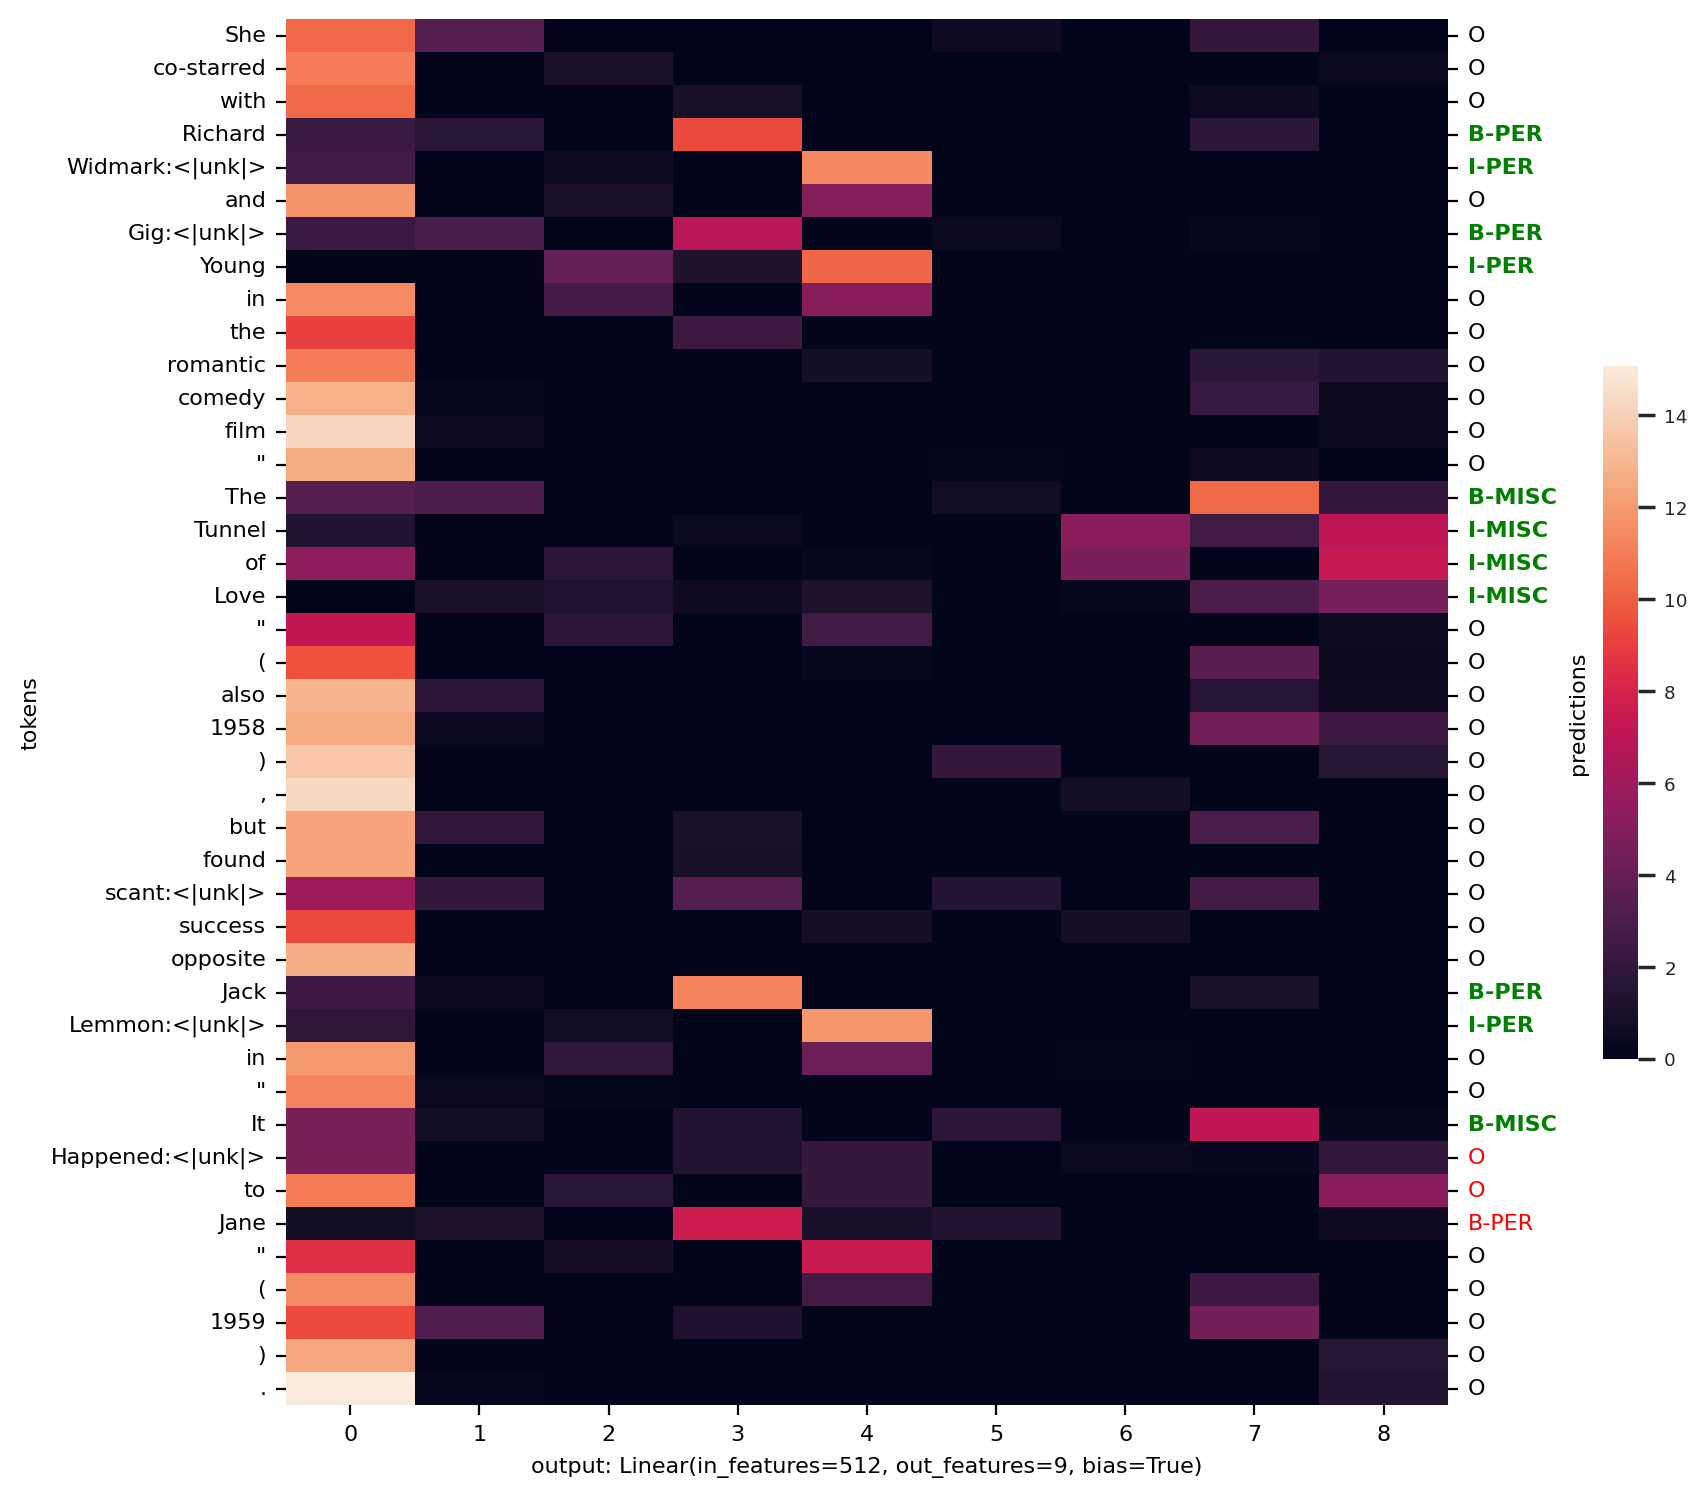

In [37]:
# Set the module you wish to visualize (format: model.model.<module-name>).
module = model.model.hidden_output

visualize_activations(
    tokenizer=tokenizer,
    model=model,
    module=module,
    text=hf_dataset[partition][sample_idx]["text"],
    labels=labels,
    nonlinearity=F.relu,
)

<a name="leaderboard_rnn"></a>

#### [$\ast$] Leaderboard submission <small>[↩︎](#outline)</small>

> __Note.__ Submitting to the leaderboard is optional, see [<sup>[2]</sup>](#optional) for baselines and related information.

Let's make a leaderboard submission using our trained RNN. Run the following cells to make a leaderboard submission. As noted before, the `make_submission` command when run with `--leaderboard-submission` flag creates a `leaderboard_submission.zip` file in `cs4740-hw2/artefacts` folder, which is to be submitted on the submission site. <font color="red">Caution: the script will overwrite any file named `leaderboard_submission.zip` existing in `cs4740-hw2/artefacts` folder.</font>

> __Tip.__ When we made a [leaderboard submission for FFNN](#leaderboard_ffnn), we ran the `train_model.py` script by setting the `--ffnn-config-path` and `--pretrained-ffnn-checkpoint-or-model-filepath` flags; these flags can be set alongside `--rnn-config-path` and `--pretrained-rnn-checkpoint-or-model-filepath` to make a concurrent FFNN and RNN leaderboard submission! <br/>
> (Run the command in [final submission](#final) section __with__ `--leaderboard-submission` flag.)

Set the `rnn_experiment_name` and `rnn_best_epoch` accordingly. The `leaderboard_submission.zip` is all that you will need to submit to the leaderboard (no need to submit anything else!).

In [38]:
# Set the following accordingly.
rnn_experiment_name = "model=rnn_layers=2_batch=128"
rnn_best_epoch = 6

In [ ]:
submission_filepath = f"{ARTEFACTS_DIR}"

rnn_config_filename =  f"experiments/{rnn_experiment_name}/config.json"
rnn_checkpoint_filename = f"experiments/{rnn_experiment_name}/checkpoints/checkpoint_{rnn_best_epoch}.ckpt"

!python -m scripts.make_submission \
    --rnn-config-path={os.path.join(ARTEFACTS_DIR, rnn_config_filename)} \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --tokenizer-filepath={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --basepath-to-store-submission={os.path.join(ARTEFACTS_DIR, submission_filepath)} \
    --pretrained-rnn-checkpoint-or-model-filepath={os.path.join(ARTEFACTS_DIR, rnn_checkpoint_filename)} \
    --leaderboard-submission

if os.path.isfile(f"{os.path.join(ARTEFACTS_DIR, 'leaderboard_submission.zip')}"):
    display(success())
else:
    print(colored("Oops, something went wrong!", "red"))

<a name="sec53"></a>

#### [5.3] Analyzing RNN <small>[↩︎](#outline)</small>

Again, be concise when answer the following questions. The goal of these questions is to get you thinking about designing and training RNNs, and are _not_ meant to be an unordered collection of all your thoughts about RNNs. Make compelling (preferably, data-backed) arguments that aren't misleading or confusing.

(Save for the optional question, all other questions in this section must be answered in under $1.5$ pages.)

---
<font color="orange">__Q5.3.1.__ In comparison to your best FFNN model, how did your best RNN model _perform_? Again, performance is more than just "performance on some metric"; it includes efficiency (e.g., training time, convergence rate), memory (e.g., weights storage), generalizability (e.g., on unknown words), etc. Choose any two dimensions and present your views.
</font>

__Answer.__

Compared to the FFNN, the RNN took longer per epoch and converged more slowly because it processes sequences sequentially rather than in parallel. However, the RNN demonstrated improved generalizability on tasks requiring context, as capturing more temporal dependencies allowed it to yield higher entity-level F1 scores, especially on tokens whose interpretation depends on earlier context.

---

<font color="orange">__Q5.3.2.__ From the (averaged) entity-level F1 score, we realize that RNN is far better performing than an FFNN (for the underlying task). Ignoring the training time, what happens if we used an RNN to process a really long sequence, say $O(2^{12})$ tokens (most large language models operate at this order)? <br/>
_Hint. Think recurrence! How much information from the first few tokens is retained in the last few timesteps?_
</font>

__Answer.__

In a vanilla RNN, while the recurrence theoretically allows for unbounded memory, in practice the repeated application of the same weight matrices causes early signals to decay exponentially, a phenomenon known as the vanishing gradient problem. For an extremely long sequence, information from the first few tokens is effectively "washed out" by the time the network reaches the last few timesteps, meaning that the hidden state is dominated by recent inputs. This loss of long-range dependencies is documented (Bengio et al., 1994), which is why architectures like Transformers with their attention mechanisms are preferred for tasks requiring retention of information across long spans.

Citation: Y. Bengio, P. Simard, and P. Frasconi, “Learning long-term dependencies with gradient descent is difficult,” *IEEE Transactions on Neural Networks*, vol. 5, no. 2, pp. 157–166, 1994.

---

<font color="orange">__Q5.3.3.__ Consider the word "Bank" in two sequences: 1) "_I went to <u>Bank</u> of America to talk to the manager_", and 2) "_I went to <u>Bank</u> to draw cash_". Would our current RNN model be able to accurately classify "Bank" in sequence-1 as "B-ORG" and the "Bank" in sequence-2 as "O"? If your answer is _yes_, then justify your answer; if your answer is _no_, then provide a suitable fix. <br/>
_Hint. Think about how our RNN model processes an input sequence._
</font>

__Answer.__

No. In a standard RNN, the prediction for a token like "Bank" is made as soon as that token is processed, only prior context is available. In sequence 1 the model wouldn’t “see” the following "of America" that signals an organization, so it might misclassify "Bank" as "O" just as in sequence 2. One fix is to use a bidirectional RNN, which processes the sequence in both directions so that each token’s representation is informed by both past and future context, allowing it to accurately classify "Bank" as "B-ORG" in sequence 1 and "O" in sequence 2.

---

<font color="orange">__[optional, ungraded] Q5.3.4.__ Visualize the activations of the modules in your trained RNN. See how activations for named-entities vary (when compared to non named-entities) as you pass through the layers of your multi-layered RNN. Are there any interesting patterns? <br/>
Again, we're not looking for one example where everthing (by some stroke of luck) looks "nice"; look for any interesting and general patterns.
</font>

__Answer.__

---

---
<a name="final"></a>

### [$\ast$] Final submission <small>[↩︎](#outline)</small>

Hurray! Now that we've succesfully trained our FFNN and RNN, let's bundle everything up and make a submission on the submission site(s). Running the cell below will generate a `hw2_submission.zip` file in the `cs4740-hw2/artefacts` folder.  <font color="red">Caution: the script will overwrite any file named `hw2_submission.zip` existing in `cs4740-hw2/artefacts` folder.</font>

Before running the cells below, set the `ffnn_experiment_name`, `ffnn_best_epoch`, `rnn_experiment_name`, and `rnn_best_epoch` accordingly. You will need to submit the `hw2_submission.zip` __and a .pdf version of this notebook file__ on the submission site(s). Note: this notebook will only be used to grade your answers to the written questions; you will _not_ be graded on any code in this notebook file.

In [39]:
# Set the following regarding your FFNN model.
ffnn_experiment_name = "model=ffnn_layers=2_batch=128"
ffnn_best_epoch = 9

In [40]:
# Set the following regarding your RNN model.
rnn_experiment_name = "model=rnn_layers=2_batch=128"
rnn_best_epoch = 6

In [41]:
submission_filepath = f"{ARTEFACTS_DIR}"

ffnn_config_filename =  f"experiments/{ffnn_experiment_name}/config.json"
ffnn_checkpoint_filename = f"experiments/{ffnn_experiment_name}/checkpoints/checkpoint_{ffnn_best_epoch}.ckpt"

rnn_config_filename =  f"experiments/{rnn_experiment_name}/config.json"
rnn_checkpoint_filename = f"experiments/{rnn_experiment_name}/checkpoints/checkpoint_{rnn_best_epoch}.ckpt"

!python -m scripts.make_submission \
    --ffnn-config-path={os.path.join(ARTEFACTS_DIR, ffnn_config_filename)} \
    --rnn-config-path={os.path.join(ARTEFACTS_DIR, rnn_config_filename)} \
    --basepath-to-hf-dataset={os.path.join(ARTEFACTS_DIR, "dataset")} \
    --tokenizer-filepath={os.path.join(ARTEFACTS_DIR, "tokenizer/tokenizer.json")} \
    --basepath-to-store-submission={os.path.join(ARTEFACTS_DIR, submission_filepath)} \
    --pretrained-ffnn-checkpoint-or-model-filepath={os.path.join(ARTEFACTS_DIR, ffnn_checkpoint_filename)} \
    --pretrained-rnn-checkpoint-or-model-filepath={os.path.join(ARTEFACTS_DIR, rnn_checkpoint_filename)} \
    --net-ids={net_ids}

if os.path.isfile(f"{os.path.join(ARTEFACTS_DIR, 'hw2_submission.zip')}"):
    display(success())
else:
    print(colored("Oops, something went wrong!", "red"))

+------------------------------+------------+---------------+
|            module            | num_params | requires_grad |
+------------------------------+------------+---------------+
|  embedding.embedding.weight  |  5050800   |      True     |
|  model.input_hidden.weight   |   153600   |      True     |
|   model.input_hidden.bias    |    512     |      True     |
| model.hidden_layers.0.weight |   262144   |      True     |
|  model.hidden_layers.0.bias  |    512     |      True     |
|  model.hidden_output.weight  |    4608    |      True     |
|   model.hidden_output.bias   |     9      |      True     |
+------------------------------+------------+---------------+
total trainable params: 5.47M
test ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:01
+------------------------------+------------+---------------+
|            module            | num_params | requires_grad |
+------------------------------+------------+---------------+
|  embedding.embedding.weight  |  5050800  

No part (code, documentation, comments, etc.) of this notebook or any assignment-related artefacts were generated/created, refined, or modified using generative AI tools such as Chat GPT. Cite this notebook as:
> Tushaar Gangavarapu, Pun Chaixanien<sup>&lowast;</sup>, Kai Horstmann<sup>&lowast;</sup>, Dave Jung<sup>&lowast;</sup>, Aaishi Uppuluri<sup>&lowast;</sup>, Lillian Lee, Darren Key<sup> &int;</sup>, Logan Kraver<sup> &int;</sup>, Lionel Tan<sup> &int;</sup>. 2023. CS 4740 Fa'23 HW2: Named-entity recognition using FFNNs and RNNs. GitHub. https://github.coecis.cornell.edu/cs4740-fa23-public/hw2-fa23/. <br/>
> &nbsp;&nbsp;&nbsp;&nbsp;<sup>&lowast;</sup>equal contribution, software creators, ordered alphabetically   &nbsp;&nbsp;&nbsp;&nbsp;<sup>&int;</sup>equal contribution, software testers, ordered alphabetically<br/>

__Acknowledgments.__ This work is inspired from the assignment "CS 4740 FA'22 HW2: Neural NER" developed by John Chung, Renee Shen, John R. Starr, Tushaar Gangavarapu, Fangcong Yin, Shaden Shaar, Marten van Schijndel, and Lillian Lee.